In [ ]:
!pip install transformers
!pip install catboost
!pip install pymorphy2

In [ ]:
import pandas as pd
import nltk
import pymorphy2
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import re
import math
import os
from numpy.random import choice
import matplotlib.pyplot as plt
import copy
import gensim
import pickle
import random
import seaborn as sb
import copy
import transformers
import numpy as np
from matplotlib.pyplot import figure
from google.colab import drive
from sklearn.metrics import roc_auc_score
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
drive.mount('/content/drive')
%cd /content/drive/My Drive/Сommonlit_SS/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Сommonlit_SS


In [ ]:
%ls /Сommonlit_SS/Data

#Постановка задачи

*The goal of this competition is to assess the quality of summaries written by students in grades 3-12. You'll build a model that evaluates how well a student represents the main idea and details of a source text, as well as the clarity, precision, and fluency of the language used in the summary. You'll have access to a collection of real student summaries to train your model.*

*Your work will assist teachers in evaluating the quality of student work and also help learning platforms provide immediate feedback to students.*

Submissions are scored using MCRMSE, mean columnwise root mean squared error:

$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\left(\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2\right)^{1/2}$


where $N_{t}$ is the number of scored ground truth target columns, and $y$ and $\hat{y}$ are the actual and predicted values, respectively.

Говоря более практично, мы предсказываем оценку за качество раскрытия темы текста и его грамматическое наполнение. У нас есть 2 колонки в summaries_train wording и content, которые мы и должны предсказывать

In [ ]:
pd.read_csv("Data/summaries_train.csv").head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


#EDA

Задача конечно "NLP-шная", поэтому привычного eda с корреляциями и тот же feature engineering тут не предвидится. Да и для трансформеров он особо не нужен. Но посмотреть на данные все же стоит

In [ ]:
file_names = ['prompts_test', 'prompts_train', 'sample_submission', 'summaries_test', 'summaries_train']

In [ ]:
for name in file_names:
  df = pd.read_csv(f"Data/{name}.csv")
  print(f"{name} len is {len(df)}")

prompts_test len is 2
prompts_train len is 4
sample_submission len is 4
summaries_test len is 4
summaries_train len is 7165


In [ ]:
pd.read_csv(f"Data/prompts_test.csv").head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [ ]:
pd.read_csv(f"Data/sample_submission.csv").head()

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [ ]:
pd.read_csv(f"Data/summaries_test.csv").head()

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [ ]:
pd.read_csv(f"Data/summaries_train.csv").head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


**Нас интересуют prompts_train и summaries_train**

In [ ]:
df_promt = pd.read_csv("Data/prompts_train.csv")

In [ ]:
df = pd.read_csv("Data/summaries_train.csv")

In [ ]:
df_promt

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [ ]:
set(df['prompt_id'])

{'39c16e', '3b9047', '814d6b', 'ebad26'}

In [ ]:
print("Display of promt text number distribution")
promt_num = {}
for i in set(df['prompt_id']):
  name = list(df_promt[df_promt['prompt_id']==i]['prompt_title'])[0]
  col = len(df[df['prompt_id']==i])
  print(f"For {name} number of texts is {col}")
  promt_num[name] = col

Display of promt text number distribution
For Excerpt from The Jungle number of texts is 1996
For Egyptian Social Structure number of texts is 2009
For On Tragedy number of texts is 2057
For The Third Wave number of texts is 1103


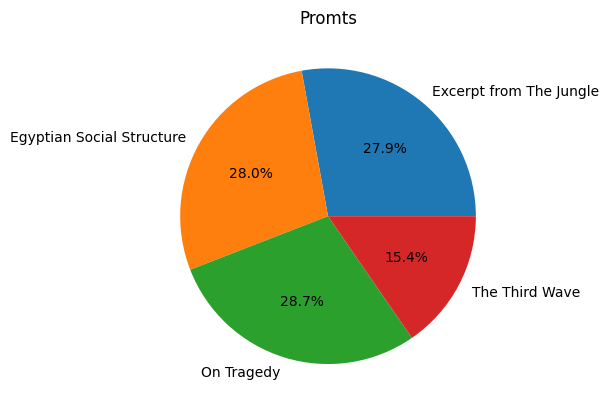

In [ ]:
import matplotlib.pyplot as plt
names = list(promt_num.keys())
numbers = list(promt_num.values())

plt.pie(numbers, labels=names, autopct='%1.1f%%')

plt.title('Promts')

plt.show()

In [ ]:
df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [ ]:
df['text'][684]

"Egyptian social structure was like a pyramid, the slaves on the bottom and the Pharaohs  we're on the top. in the text it says. ¨At the bottom of the social structure were slaves and farmers.¨ This shows that slaves and farmers were on the bottom. In the text it says¨ Their leaders, called pharaohs, were believed to be gods in human form.¨ This shows that the Pharaoh was on the top of the social pyramid. "

Видим, что распределение по темам примерно равное. Если посмотреть на тексты тем вручную, то честно сказать, ничего интересного я там не увидел. Так что как сам датасет по темам, можно использовать и без балансировки.
P.S.Я вообще, большой любитель аугментации. НО, в данной задаче совершенно не ясно каким образом ставиться итоговая оценка текста. То есть, авторы дают следующие критерии: 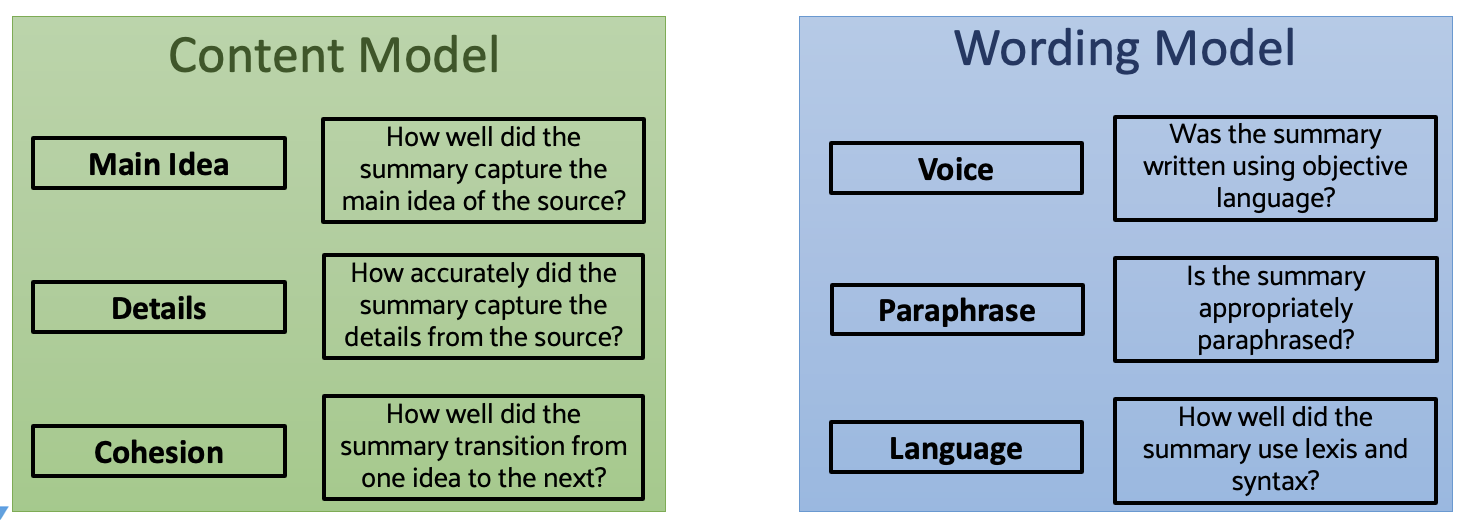
Но каким образом они конвертируются в числовую оценку не ясно совершенно. Поэтому какой-либо доп. аугментации я решил на этот раз избегать. К тому же, с эти есть еще одна проблема о которой позже

**Теперь посмотрим на сами оценки**

In [ ]:
Pscatter_dict = {}

In [ ]:
for i in df['wording']:
  if i in scatter_dict:
    scatter_dict[i]+=1
  else:
    scatter_dict[i]=1

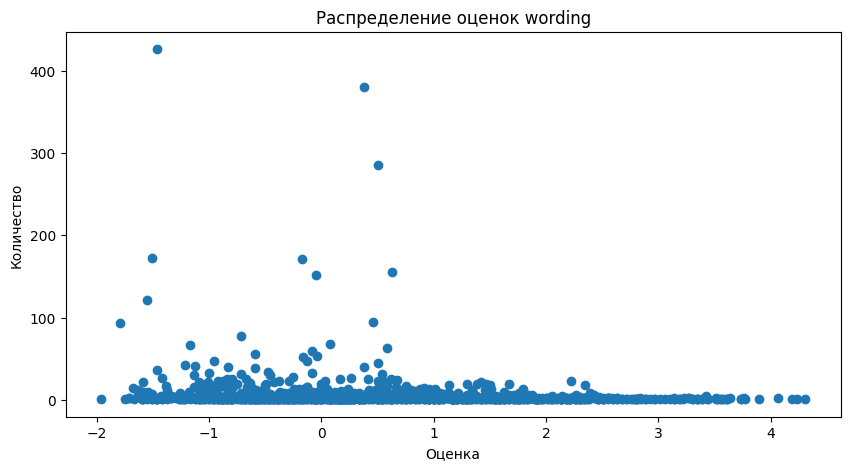

In [ ]:
import matplotlib.pyplot as plt
data = scatter_dict

ratings = list(data.keys())
counts = list(data.values())


plt.figure(figsize=(10,5))
plt.scatter(ratings, counts)


plt.title('Распределение оценок wording')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()


In [ ]:
scatter_dict = {}

In [ ]:
sorted(scatter_dict)

In [ ]:
for i in df['content']:
  if i in scatter_dict:
    scatter_dict[i]+=1
  else:
    scatter_dict[i]=1

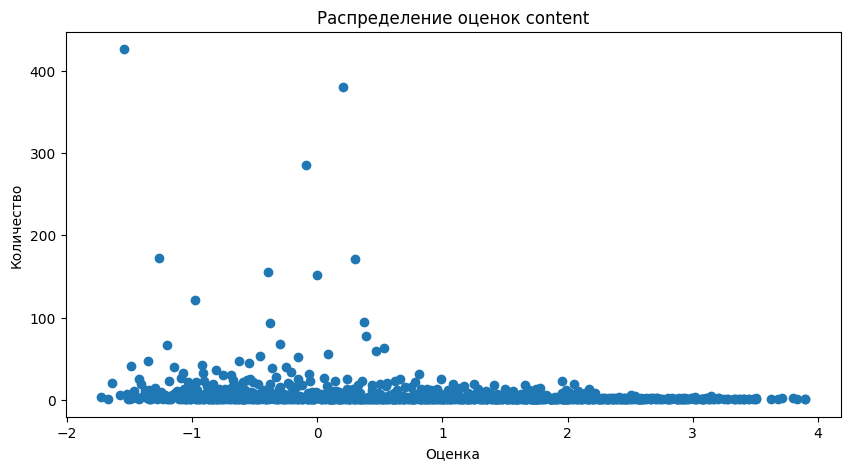

In [ ]:
import matplotlib.pyplot as plt
data = scatter_dict

ratings = list(data.keys())
counts = list(data.values())


plt.figure(figsize=(10,5))
plt.scatter(ratings, counts)


plt.title('Распределение оценок content')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()


Собственно, информации каким образом получено было число и почему оно от -2 до 4 я найти так и не смог, так что оставим это как данность.

Для тем ситуация +/- аналогичная

In [ ]:
scatter_dict = {}

In [ ]:
for i in df[df['prompt_id']=='39c16e']['content']:
  if i in scatter_dict:
    scatter_dict[i]+=1
  else:
    scatter_dict[i]=1

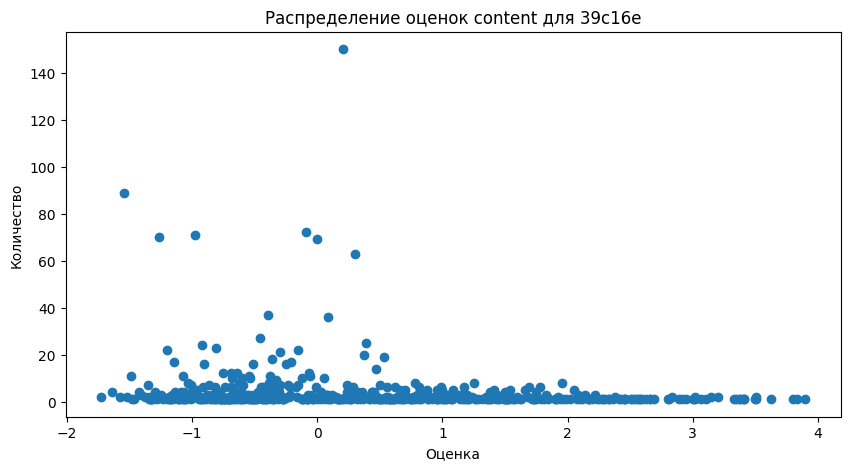

In [ ]:
import matplotlib.pyplot as plt
data = scatter_dict

ratings = list(data.keys())
counts = list(data.values())


plt.figure(figsize=(10,5))
plt.scatter(ratings, counts)


plt.title('Распределение оценок content для 39c16e')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()


Для остальных примерно тоже самое. Так что датасет можно назвать уже вполе пригодным для обучения. Так как я изначально ориентировался не на традиционные методы машинного обучения, а на трансформеры, этого мне вполне достаточно для начала. Остальное уже будет за архитектурой и моделями. Единственное что, я еще решил посмотреть базовые корреляции по пирсону. На случай чего-то интересного

In [ ]:
df

In [ ]:
df["words"] = df['text'].apply(lambda x: len(x.split(' ')))
df["sentences"] = df['text'].apply(lambda x: len(x.split('.')))
df["len"] = df['text'].apply(lambda x: len(x))
df = df.drop(['student_id','prompt_id','text'], axis = 1)

In [ ]:
df

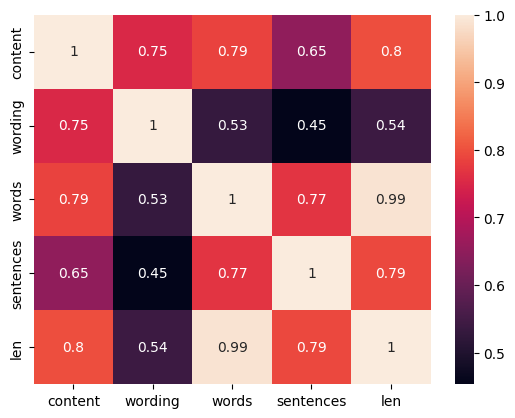

In [ ]:
dt = sb.heatmap(df.corr(),  annot=True)

В целом ожидаемый результат. Я смотрел и другие фичи, но так как мне они особо не нужны были пока, оставил для обзора эти. Что интересно, content и кол-во слов имеют достаточно высокую корреляцию. Но непосредственно для улучшения качества трансформера мне это пока не пригодилось

Вообще с этими фичами достаточно интересно получилось, о чем дальше

# TF-IDF и Bag of words

Так, тут сразу стоит обозначить какая ситуация с этими методами. Изначально я и не предполагал их использовать вообще. Так как достаточно общеизвестно превосходство трансформеров для подобных задач над классическими методами, да и в лидерборде в основном были именно нейросетевые подходы. Но затем я наткнулся на следующее решение этой задачи без любых эмбедингов вообще. [Тык](https://www.kaggle.com/code/bulivington/no-transformers-but-not-so-bad) Лишь с фичам общей инфорации о тексте. С очень неплохим скором для подобного подхода, как мне показалось.

Поэтому я дополнительно решил дополнительно взять и посмотреть какой скор получиться с применением этих методов. Так как к тому моменту у меня уже был набор для тестирования и обучения, использовал его (о нем позже). В качестве модели решил взять CatBoost, как один из наиболее оптимальных вариантов. Его преимущества, думаю, расписывать в очередной раз смысла не имеет. Ну и соответствующие методы из sklearn.

##TF-IDF

In [ ]:
train = pd.read_csv("TTV/train.csv")
test = pd.read_csv("TTV/test.csv")
validate = pd.read_csv("TTV/validate.csv")

In [ ]:
train

,student_id,prompt_id,text,content,wording
0,3239b8fac7a5,814d6b,The Third Wave developed over such a short per...,1.467431,1.840172
1,d6ab90f1172f,39c16e,An ideal tragedy described by Aristotle would ...,0.022756,-0.959684
2,fbafcc2cfd69,ebad26,The factory would use soda to take the bad sme...,-0.157460,-0.165811
3,0d4540fde41e,39c16e,One element of an ideal tragedy is when the ch...,0.297031,-0.168734
4,a670f5b7eccf,ebad26,They would just add other meat that they had. ...,-1.102198,-0.587213
...,...,...,...,...,...
5727,44f874610a41,3b9047,back during this time if u wernt a godor a typ...,-1.467820,-0.828892
5728,45e0bb7dedf7,ebad26,Meat would be rubbed with soda to mask the odo...,-1.125231,-0.537431
5729,9f678c96b72f,ebad26,The factory used anything and everything to se...,0.467722,-0.085653
5730,bf2bed944599,39c16e,One element is that a tragedy should be arrang...,0.531368,0.583991


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

In [ ]:
X = vectorizer.fit_transform(train['text'])

In [ ]:
df = pd.DataFrame(X.toarray())
df['content'] = pd.read_csv("TTV/train.csv")['content']
df['wording'] = pd.read_csv("TTV/train.csv")['wording']
train = df

In [ ]:
X = vectorizer.transform(test['text'])

In [ ]:
df = pd.DataFrame(X.toarray())
df['content'] = pd.read_csv("TTV/test.csv")['content']
df['wording'] = pd.read_csv("TTV/test.csv")['wording']
test = df

In [ ]:
X = vectorizer.transform(validate['text'])

In [ ]:
df = pd.DataFrame(X.toarray())
df['content'] = pd.read_csv("TTV/validate.csv")['content']
df['wording'] = pd.read_csv("TTV/validate.csv")['wording']
validate = df

In [ ]:
validate

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,content,wording
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.419499,0.300379
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.088882,-0.594710
2,0.000000,0.0,0.000000,0.000000,0.000000,0.239984,0.0,0.000000,0.32768,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.773117,-1.122924
3,0.363756,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.365608,-0.591788
4,0.000000,0.0,0.000000,0.000000,0.000000,0.161093,0.0,0.234889,0.00000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.300493,-1.463167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.000000,0.0,0.343760,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.315952,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.602425,-1.039843
712,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-1.264214,-1.505073
713,0.000000,0.0,0.000000,0.000000,0.129336,0.000000,0.0,0.147035,0.00000,0.000000,...,0.132985,0.137535,0.0,0.0,0.134614,0.0,0.0,0.143917,1.237099,1.421802
714,0.000000,0.0,0.000000,0.000000,0.000000,0.286477,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.970237,-0.417058


In [ ]:
params = {
    'learning_rate': 0.01,
    'depth': 6,
    'l2_leaf_reg': 3,
    'iterations': 5000,
    'loss_function': 'RMSE',
    'task_type': 'CPU',
    'verbose': 100
}

In [ ]:
from catboost import Pool, CatBoostRegressor
X_train = train.drop(columns=['content', 'wording'])
y_train_content = train['content']
y_train_wording = train['wording']

X_test = test.drop(columns=['content', 'wording'])
y_test_content = test['content']
y_test_wording = test['wording']

train_pool = Pool(X_train, y_train_content)
valid_pool = Pool(X_test, y_test_content)

In [ ]:
model_content = CatBoostRegressor(**params)
model_content.fit(train_pool, eval_set=valid_pool)

0:	learn: 1.0459490	test: 1.0570473	best: 1.0570473 (0)	total: 75.9ms	remaining: 6m 19s
100:	learn: 0.9059210	test: 0.9280320	best: 0.9280320 (100)	total: 4.19s	remaining: 3m 23s
200:	learn: 0.8215648	test: 0.8527409	best: 0.8527409 (200)	total: 7s	remaining: 2m 47s
300:	learn: 0.7655674	test: 0.8018911	best: 0.8018911 (300)	total: 9.72s	remaining: 2m 31s
400:	learn: 0.7247989	test: 0.7676849	best: 0.7676849 (400)	total: 12.5s	remaining: 2m 23s
500:	learn: 0.6928992	test: 0.7402731	best: 0.7402731 (500)	total: 17.7s	remaining: 2m 38s
600:	learn: 0.6698047	test: 0.7206595	best: 0.7206595 (600)	total: 20.8s	remaining: 2m 31s
700:	learn: 0.6515349	test: 0.7049282	best: 0.7049282 (700)	total: 23.5s	remaining: 2m 24s
800:	learn: 0.6365153	test: 0.6926280	best: 0.6926280 (800)	total: 26.3s	remaining: 2m 17s
900:	learn: 0.6228904	test: 0.6818062	best: 0.6818062 (900)	total: 29.9s	remaining: 2m 15s
1000:	learn: 0.6107802	test: 0.6733967	best: 0.6733967 (1000)	total: 34.6s	remaining: 2m 18s
110

In [ ]:
train_pool_wording = Pool(X_train, y_train_wording)
valid_pool_wording = Pool(X_test, y_test_wording)

model_wording = CatBoostRegressor(**params)
model_wording.fit(train_pool_wording, eval_set=valid_pool_wording)

0:	learn: 1.0373655	test: 1.0634040	best: 1.0634040 (0)	total: 34ms	remaining: 2m 49s
100:	learn: 0.9383839	test: 0.9592082	best: 0.9592082 (100)	total: 3.5s	remaining: 2m 49s
200:	learn: 0.8891427	test: 0.9150683	best: 0.9150683 (200)	total: 7.84s	remaining: 3m 7s
300:	learn: 0.8561862	test: 0.8870559	best: 0.8870559 (300)	total: 10.4s	remaining: 2m 42s
400:	learn: 0.8322723	test: 0.8684479	best: 0.8684479 (400)	total: 12.9s	remaining: 2m 28s
500:	learn: 0.8138196	test: 0.8546888	best: 0.8546888 (500)	total: 15.5s	remaining: 2m 18s
600:	learn: 0.7997719	test: 0.8451454	best: 0.8451454 (600)	total: 18.9s	remaining: 2m 18s
700:	learn: 0.7873812	test: 0.8369524	best: 0.8369524 (700)	total: 22.9s	remaining: 2m 20s
800:	learn: 0.7761713	test: 0.8300770	best: 0.8300770 (800)	total: 25.4s	remaining: 2m 13s
900:	learn: 0.7652948	test: 0.8237506	best: 0.8237506 (900)	total: 27.9s	remaining: 2m 6s
1000:	learn: 0.7541506	test: 0.8181209	best: 0.8181209 (1000)	total: 30.4s	remaining: 2m 1s
1100:	

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from catboost import Pool


X_validate = validate.drop(columns=['content', 'wording'])
validate_pool_wording = Pool(X_validate)
validate_pool_content = Pool(X_validate)


wording_pred = model_wording.predict(validate_pool_wording)
content_pred = model_content.predict(validate_pool_content)


w_rmse = sqrt(mean_squared_error(validate['wording'], wording_pred))
print(f"Wording r2 score: {r2_score(validate['wording'], wording_pred)}")
print(f"Wording mse score: {mean_squared_error(validate['wording'], wording_pred)}")
print(f"Wording rmse score: {w_rmse}")
print(f"Wording mape score: {mean_absolute_percentage_error(validate['wording'], wording_pred)}")


c_rmse = sqrt(mean_squared_error(validate['content'], content_pred))
print(f"Content r2 score: {r2_score(validate['content'], content_pred)}")
print(f"Content mse score: {mean_squared_error(validate['content'], content_pred)}")
print(f"Content rmse score: {c_rmse}")
print(f"Content mape score: {mean_absolute_percentage_error(validate['content'], content_pred)}")


print(f"Overall MCRMSE score: {(w_rmse+c_rmse)/2.0}")

Wording r2 score: 0.4578459024948618
Wording mse score: 0.5219267851378149
Wording rmse score: 0.722445004922738
Wording mape score: 3.3781979265582307
Content r2 score: 0.6610954028754885
Content mse score: 0.3319552316409001
Content rmse score: 0.576155562015069
Content mape score: 6.486220078623662
Overall MCRMSE score: 0.6493002834689034


##Bag of words

In [ ]:
train = pd.read_csv("TTV/train.csv")
test = pd.read_csv("TTV/test.csv")
validate = pd.read_csv("TTV/validate.csv")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=100)

In [ ]:
X = vectorizer.fit_transform(train['text'])

In [ ]:
df = pd.DataFrame(X.toarray())
df['content'] = pd.read_csv("TTV/train.csv")['content']
df['wording'] = pd.read_csv("TTV/train.csv")['wording']
train = df

In [ ]:
X = vectorizer.transform(test['text'])

In [ ]:
df = pd.DataFrame(X.toarray())
df['content'] = pd.read_csv("TTV/test.csv")['content']
df['wording'] = pd.read_csv("TTV/test.csv")['wording']
test = df

In [ ]:
X = vectorizer.transform(validate['text'])

In [ ]:
df = pd.DataFrame(X.toarray())
df['content'] = pd.read_csv("TTV/validate.csv")['content']
df['wording'] = pd.read_csv("TTV/validate.csv")['wording']
validate = df

In [ ]:
validate

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,content,wording
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.419499,0.300379
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.088882,-0.594710
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.773117,-1.122924
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.365608,-0.591788
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0.300493,-1.463167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,-0.602425,-1.039843
712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.264214,-1.505073
713,0,0,0,0,1,0,0,1,0,0,...,1,1,0,0,1,0,0,1,1.237099,1.421802
714,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.970237,-0.417058


In [ ]:
y_train_content

In [ ]:
train_pool_content = Pool(X_train, y_train_content)
valid_pool_content = Pool(X_test, y_test_content)

model_content = CatBoostRegressor(**params)
model_content.fit(train_pool_content, eval_set=valid_pool_content)

0:	learn: 1.0459490	test: 1.0570473	best: 1.0570473 (0)	total: 116ms	remaining: 9m 39s
100:	learn: 0.9059210	test: 0.9280320	best: 0.9280320 (100)	total: 8.02s	remaining: 6m 28s
200:	learn: 0.8215648	test: 0.8527409	best: 0.8527409 (200)	total: 10.7s	remaining: 4m 16s
300:	learn: 0.7655674	test: 0.8018911	best: 0.8018911 (300)	total: 13.4s	remaining: 3m 29s
400:	learn: 0.7247989	test: 0.7676849	best: 0.7676849 (400)	total: 16.2s	remaining: 3m 5s
500:	learn: 0.6928992	test: 0.7402731	best: 0.7402731 (500)	total: 20.9s	remaining: 3m 7s
600:	learn: 0.6698047	test: 0.7206595	best: 0.7206595 (600)	total: 24.4s	remaining: 2m 58s
700:	learn: 0.6515349	test: 0.7049282	best: 0.7049282 (700)	total: 27.7s	remaining: 2m 50s
800:	learn: 0.6365153	test: 0.6926280	best: 0.6926280 (800)	total: 31.8s	remaining: 2m 46s
900:	learn: 0.6228904	test: 0.6818062	best: 0.6818062 (900)	total: 39.4s	remaining: 2m 59s
1000:	learn: 0.6107802	test: 0.6733967	best: 0.6733967 (1000)	total: 44.2s	remaining: 2m 56s
110

In [ ]:
train_pool_wording = Pool(X_train, y_train_wording)
valid_pool_wording = Pool(X_test, y_test_wording)

model_wording = CatBoostRegressor(**params)
model_wording.fit(train_pool_wording, eval_set=valid_pool_wording)

0:	learn: 1.0373655	test: 1.0634040	best: 1.0634040 (0)	total: 37.6ms	remaining: 3m 7s
100:	learn: 0.9383839	test: 0.9592082	best: 0.9592082 (100)	total: 2.78s	remaining: 2m 15s
200:	learn: 0.8891427	test: 0.9150683	best: 0.9150683 (200)	total: 5.49s	remaining: 2m 11s
300:	learn: 0.8561862	test: 0.8870559	best: 0.8870559 (300)	total: 8.2s	remaining: 2m 8s
400:	learn: 0.8322723	test: 0.8684479	best: 0.8684479 (400)	total: 12.9s	remaining: 2m 27s
500:	learn: 0.8138196	test: 0.8546888	best: 0.8546888 (500)	total: 16.4s	remaining: 2m 27s
600:	learn: 0.7997719	test: 0.8451454	best: 0.8451454 (600)	total: 19.1s	remaining: 2m 19s
700:	learn: 0.7873812	test: 0.8369524	best: 0.8369524 (700)	total: 21.9s	remaining: 2m 14s
800:	learn: 0.7761713	test: 0.8300770	best: 0.8300770 (800)	total: 25s	remaining: 2m 11s
900:	learn: 0.7652948	test: 0.8237506	best: 0.8237506 (900)	total: 30.1s	remaining: 2m 16s
1000:	learn: 0.7541506	test: 0.8181209	best: 0.8181209 (1000)	total: 32.8s	remaining: 2m 11s
1100:

In [ ]:
X_validate

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
713,0,0,0,0,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,1
714,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from catboost import Pool


X_validate = validate.drop(columns=['content', 'wording'])
validate_pool_wording = Pool(X_validate)
validate_pool_content = Pool(X_validate)


wording_pred = model_wording.predict(validate_pool_wording)
content_pred = model_content.predict(validate_pool_content)


w_rmse = sqrt(mean_squared_error(validate['wording'], wording_pred))
print(f"Wording r2 score: {r2_score(validate['wording'], wording_pred)}")
print(f"Wording mse score: {mean_squared_error(validate['wording'], wording_pred)}")
print(f"Wording rmse score: {w_rmse}")
print(f"Wording mape score: {mean_absolute_percentage_error(validate['wording'], wording_pred)}")


c_rmse = sqrt(mean_squared_error(validate['content'], content_pred))
print(f"Content r2 score: {r2_score(validate['content'], content_pred)}")
print(f"Content mse score: {mean_squared_error(validate['content'], content_pred)}")
print(f"Content rmse score: {c_rmse}")
print(f"Content mape score: {mean_absolute_percentage_error(validate['content'], content_pred)}")


print(f"Overall MCRMSE score: {(w_rmse+c_rmse)/2.0}")

Wording r2 score: 0.19602764184261312
Wording mse score: 0.7739768271856988
Wording rmse score: 0.8797595280448509
Wording mape score: 3.528450673166847
Content r2 score: 0.3585085062483171
Content mse score: 0.6283374708126832
Content rmse score: 0.7926774065234125
Content mape score: 7.373765813394023
Overall MCRMSE score: 0.8362184672841317


## Non NN ways results

Видно, что в целом эти подходы выдают вполне адекватный результат. Более того,  за то время, что они обучаются( Буквально пару минут) результат достаточно неплохой. Конечно, тут я еще немного поподбирал параметры gridsearch-ем, но это тоже не занимало много времени. Сравнивая с результатами приведенной выше статьи:
*   content_rmse: 0.5441925930796591
*   wording_rmse: 0.7985275028997656
*   mcrmse: 0.6713600479897124

Можно увидеть превосходство традиционных методов NLP над простым созданием фич из текста. Да, скор tf-idf примерно на одном уровне, а BoW даже хуже. Но ведь тут затраты времени, по сравнению с созданием и модерацией кучи колонок просто минимальны. А результат уже лучше после 4 минут обучения почти такой же. При должном подборе гиперпараметров и большем кол-ве иттераций добиться скора лучше можно намного легче, чем на подходе с фичами из текста.

Но это я так, сделал ради интереса. Все равно основной упор и скор был сделан с помощью трансформеров


#Training sets & Info

Собственно, немного о том, что я собирался сделать и что сделал

---

Как показано выше, в датасете у текста есть темы. В train части их 4.

*   Excerpt from The Jungle
*   Egyptian Social Structure
*   On Tragedy
*   The Third Wave

Поэтому первой идеей было брать одну модель для общей оценки wording части, как не зависящей от содержания, лишь от грамматики и логики. И по модели на каждую тему. Так как уменьшался бы train датасет, то и время обучения уменьшалось бы соответсвенно, в результате это не должно было быть проблемой. Да и помещалось бы все это в видеопамяти проще. Поэтому решено было использовать класс трансформера под регрессию и лишь обучать на нескольких наборах под конкретную задачу. Я остановился на bert. Что это такое, и какая за ним лежит логика, думаю, повторять не стоит. Все прекрасно это знают. Это даже разбиралось на курсе. От задач классификации разница тут минимальная(в контексте самого bert и класса)


*Тут стоит сказать, что я для себя выбрал тут направление не в сторну рассмотрения принципиально различных путей обучения и рассмотрения разных кастомных реализаций bert моделей. Мне было интересно посмотреть именно влияние предобученных вариантов и их параметров на обучение в конретной ситуации. Чтобы в дальнейшем лучше понимать какие из представленных предобученных варинтов наиболее оптимальны. Поэтому я углубился в тестирование в рамках моей реализации, а не искал другие. К тому же, из-за одной проблемы, о которой потом, это был верный вариант*



---
По поводу предобработки. Может возникнуть вопрос - где она? Собственно отвечу. Так как тут присутствует критерий wording, то стемминг и лемматизация я как-то проводить не захотел. Более того, в одной из моих ранних попыток обучения я сравнил bert-base-uncased на 5 эпохах с и без лемматизацией. К сожалению, точные скоры где-то потерял. Но разница была что-то около 0.03 по MCRMSE в пользу отсутсвия последней. Меня это как-то смутило, но я решил уже тестировать без. К тому же, в рамках bert-подобных моделей это менее критично, чем для классических методов. Так что в большинстве из представленных тестов обучение проиходило без лемантизации, а с лишь небольшими изменениями исходного текста (убраны стоп слова, пунктуация). Но код для лемантизации ниже.




---

Собственно далее для начала я подготовил данные. А именно применил описанные выше методы предобработки и разбил выборку на train/test/validation. Таким образом стало доступно сравнение разных моделей т.к. обучающая выборка была уже заранее подготовленна. Появилась также и часть для валидации, по которой и вычислялись выбранные метрики

In [ ]:
data = pd.read_csv("Data/summaries_train.csv")
data

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128


In [ ]:
train, test, validate = np.split(data.sample(frac=1, random_state=55),
                       [int(.8*len(data)), int(.9*len(data))])

In [ ]:
import os

path = "TTV"
if not os.path.exists(path):
    os.makedirs(path)
print(1)

1


In [ ]:
train.to_csv("TTV/train.csv", index=False)
validate.to_csv("TTV/test.csv", index=False)
test.to_csv("TTV/validate.csv", index=False)

In [ ]:
train, test, validate = np.split(data.sample(frac=1, random_state=42),
                       [int(.8*len(data)), int(.9*len(data))])

train.to_csv("Data/train_clear.csv", index = False)
validate.to_csv("Data/test_clear.csv", index = False)
test.to_csv("Data/validate_clear.csv", index = False)

In [ ]:
train = pd.read_csv("Data/train_clear.csv")
validate = pd.read_csv("Data/test_clear.csv")
test = pd.read_csv("Data/validate_clear.csv")

In [ ]:
train

,student_id,prompt_id,text,content,wording
1706,3da59a1b970f,3b9047,The Pharaohs were leaders or believed to be go...,0.205683,0.380538
457,112abaf5917d,3b9047,The Egyptian system of government was str...,-0.393310,0.627128
6508,e87808d11c34,ebad26,They would use every single piece of meat they...,0.205683,0.380538
5690,cac8623cbb88,ebad26,"When meat spoiled, the factory would can the m...",1.268807,0.537241
6844,f4600c21b673,39c16e,It should be complex that excites pity and fea...,-1.376472,-1.378164
...,...,...,...,...,...
4688,a589f69b65fd,814d6b,Even in the begining teh teacher had begun to ...,0.440020,1.133263
5399,bffc192ac377,39c16e,An ideal tragedy story would start with a norm...,0.285026,1.012890
1387,3239b8fac7a5,814d6b,The Third Wave developed over such a short per...,1.467431,1.840172
6720,f06122acf5bf,3b9047,The Egyptian System of government was people s...,-1.012973,-0.664340


Также я дополнительно провел проверку, чтобы разбиение по темам в train части было примерно таким же как и в исходном датасете. Ниже представлен график

In [ ]:
df = train

In [ ]:
print("Display of promt text number distribution")
promt_num = {}
for i in set(df['prompt_id']):
  name = list(df_promt[df_promt['prompt_id']==i]['prompt_title'])[0]
  col = len(df[df['prompt_id']==i])
  print(f"For {name} number of texts is {col}")
  promt_num[name] = col

Display of promt text number distribution
For On Tragedy number of texts is 1650
For Excerpt from The Jungle number of texts is 1626
For The Third Wave number of texts is 871
For Egyptian Social Structure number of texts is 1585


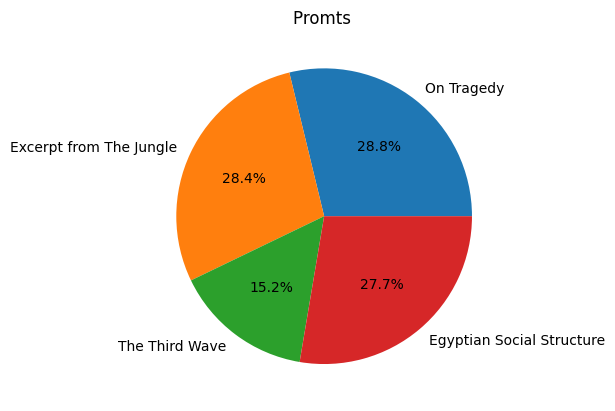

In [ ]:
import matplotlib.pyplot as plt
names = list(promt_num.keys())
numbers = list(promt_num.values())

plt.pie(numbers, labels=names, autopct='%1.1f%%')

plt.title('Promts ')

plt.show()

Для сравения вот из исходного:

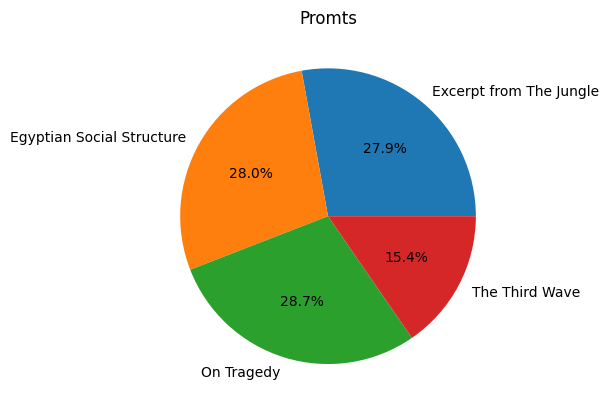

Да, некотрые изменения есть. Но соотношения примерно те же

In [ ]:
def remove_punctuation(text):
    for i in text:
        if not i.isalnum():
            text = text.replace(i, ' ')
    return "".join(text).lower()

def split(text):
  return [w for w in text.split()]

def remove_stop_words(text):
  return [w for w in text if w not in stopwords.words('english')]

def remove_numbers(text):
  return [w for w in text if not w.isnumeric()]

snowball = SnowballStemmer(language="english")
def stemming(text):
  return [snowball.stem(w) for w in text]

morph = pymorphy2.MorphAnalyzer()
def lemmatize(text):
  return [morph.parse(w)[0].normal_form for w in text]


def join(text):
    return " ".join(text)

In [ ]:
train = pd.read_csv("Data/train_clear.csv")
validate = pd.read_csv("Data/test_clear.csv")
test = pd.read_csv("Data/validate_clear.csv")

In [ ]:
preprocess_functions = [remove_punctuation, split, remove_stop_words, remove_numbers, lemmatize, join]
for function in preprocess_functions:
  train['text'] = train['text'].apply(function)
  validate['text'] = validate['text'].apply(function)
  test['text'] = test['text'].apply(function)
print(" finished")

 finished


In [ ]:
import os

path = "Cleaned_lemm"
prip = "lemm"
if not os.path.exists(path):
    os.makedirs(path)
print(1)

1


In [ ]:
train['text'][228]

'structure ancient egyptian goverment tall buildings people put hard work people would put gods top slaves bottom different social classes involved goverment slaves hard work farmers hard work pharaohs worshiped people liked high level employees mastered rare skill ancient egypt read write pharaoh profited tributes soilders skilled bottom slaves farmers higher classes got involve goverment'

In [ ]:
train.to_csv(path+f"/train_{prip}.csv", index = False)
validate.to_csv(path+f"/test_{prip}.csv", index = False)
test.to_csv(path+f"/validate_{prip}.csv", index = False)

#Bert Classes

Тут представлена реализация классов, которые и использовались при обучении на основных тестах. Это итоговая версия, которая и применялось мной для решения задчи. Я пробовал еще 2 архитектуры, но результат мне показался хуже. Также этот код крайне легко переделать под задачу классификации. Эту модифицировнную версию я уже пробовал и она показала неплохие результаты

**DataImputer**

Представляет собой стандартный класс для предварительной обработки и токенизации текстовых данных при помощи заданного токенизатора. Каждый текст преобразуется в набор токенов с соответствующей маской внимания и целевым значением, причем максимальная длина каждого текста ограничена заданным значением max_len. Ну и так как задача регрессии, то выходной тип - float. Токенизатор будем использовать из bert и его версий на huggingface

In [ ]:
import torch
from torch.utils.data import Dataset

class DataImputer(Dataset):
    def __init__(self,
                 data,
                 y_values,
                 tknr,
                 ml):
        self.data = data
        self.y = y_values
        self.tokenizer = tknr
        self.max_len = ml

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encoded = self.encode_text(str(self.data[idx]))

        return {
            'text': str(self.data[idx]),
            'input_ids': np.ravel(encoded['input_ids']),
            'attention_mask': np.ravel(encoded['attention_mask']),
            'targets': torch.tensor(self.y[idx], dtype=torch.float)
        }

    def encode_text(self, val):
        return self.tokenizer.encode_plus(
            val,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )


**BertRegressor**

Основной инструмент для выполнения регрессии с использованием BERT. Покрывает все этапы работы: от загрузки и подготовки данных до валидации и предсказаний. Стоит также сказать, что благодарю строению класса он буквально


---


**init**

Метод инициализации для BertRegressor. Он либо загружает предварительно обученную модель BERT с huggingface или локальной директории, либо существующую модель из указанного файла. Также определяется токенизатор для предобработки текстовых данных. В дополнение к этому, инициализируются базовые настройки, такие как максимальная длина последовательности, количество эпох и путь для сохранения модели.


---


**load_data**

Этот метод занимается подготовкой данных для дальнейшего обучения и валидации. На вход он принимает обучающие и тестовые наборы данных, преобразует их в специфические для BERT форматы, инициализирует загрузчики данных для последующего итерирования по ним. Помимо этого, метод определяет оптимизатор для обновления весов модели(AdamW как достаточно универсальный вариант для подобных задач), планировщик, функцию потерь(в нашем случае MSE, как близкую к метрике задачи), которая будет минимизироваться в процессе обучения


---


**fit**

Метод обучения модели на переданных обучающих данных. В процессе обучения веса модели корректируются, с вычисленными на основе функции потерь. В конце каждой итерации, градиенты обрезаются для предотвращения "взрыва" градиентов. Также добавлены функции для ранней остановки и упрощения логирования. Метод возвращает среднее значение функции потерь для всего обучающего набора данных.


---


**eval**

Метод для оценки качества модели на тестовом наборе данных. Во время этой оценки веса модели не обновляются. Позволяет проверить, насколько хорошо модель обобщает информацию на новые данные. Возвращает среднее значение функции потерь на тестовом наборе данных.


---


**train**

Этот метод объединяет процессы обучения и валидации, пройдя через заданное количество эпох. После каждой эпохи модель оценивается на валидационных данных. Если текущая модель показывает лучшее качество (меньше потерь), чем лучшая ранее сохраненная модель, то текущая модель сохраняется. Основной цикл обучения


---


**predict**

Метод предсказания, который принимает на вход текстовые данные и возвращает числовое значение, представляющее собой результат регрессии. Также этот метод сохраняет используемый токенизатор в файл для последующего использования

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import time
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

class BertRegressor:

    def __init__(self, pretrained_tokenizer_path=None,  pretrained_model_path = None, epochs=3, batch_size = 12, learning_rate = 3e-5,
                 save_path='model.pt', model_load_path='', tokenizer=None, nam = 'bert'):
        if  pretrained_model_path == None:
          self.model = torch.load(model_load_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        else:
          self.model = BertForSequenceClassification.from_pretrained( pretrained_model_path, num_labels=1)
        if pretrained_tokenizer_path == None:
          self.tokenizer = tokenizer
        else:
          self.tokenizer = BertTokenizer.from_pretrained(pretrained_tokenizer_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.save_path=save_path
        self.max_len = 512
        self.max_len = 512
        self.max_len = 512
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.model.to(self.device)
        self.nam = nam

    def load_data(self, X_train, y_train, X_test, y_test):
        self._init_datasets(X_train, y_train, X_test, y_test)
        self._init_dataloaders()
        self._init_optim_scheduler_and_loss()

    def _init_datasets(self, X_train, y_train, X_test, y_test):
        self.train_imputer = DataImputer(X_train, y_train, self.tokenizer, self.max_len)
        self.test_imputer = DataImputer(X_valid, y_valid, self.tokenizer, self.max_len)

    def _init_dataloaders(self):
        self.train_data_loaded = DataLoader(self.train_imputer, batch_size=self.batch_size, shuffle=True)
        self.test_data_loaded = DataLoader(self.test_imputer, batch_size=self.batch_size, shuffle=True)

    def _init_optim_scheduler_and_loss(self, optimizer_class=None, loss_fn=None):
        if optimizer_class is None:
            self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate, correct_bias=False)
        else:
            self.optimizer = optimizer_class(self.model.parameters())

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_data_loaded) * self.epochs
        )

        if loss_fn is None:
            self.loss_fn = torch.nn.MSELoss().to(self.device)
        else:
            self.loss_fn = loss_fn.to(self.device)

    def fit(self, logging_interval=100, early_stopping_rounds=None):
      self.model = self.model.train()
      if early_stopping_rounds:
        best_loss = float('inf')
        rounds_without_improvement = 0

      losses = []
      start_time = time.time()
      for i, data in enumerate(tqdm(self.train_data_loaded, desc="Training")):
        input_ids = data["input_ids"].to(self.device)
        attention_mask = data["attention_mask"].to(self.device)
        targets = data["targets"].to(self.device)

        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )

        loss = self.loss_fn(outputs.logits.squeeze(-1), targets)
        losses.append(loss.item())

        if i % logging_interval == 0:
            print(f"Step {i} - Loss: {np.mean(losses)}")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()
        self.optimizer.zero_grad()

        if early_stopping_rounds:
            current_loss = np.mean(losses)
            if current_loss < best_loss:
                best_loss = current_loss
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1
                if rounds_without_improvement >= early_stopping_rounds:
                    print("Early stopping due to no improvement in loss.")
                    break
      train_loss = np.mean(losses)
      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"Training completed in {elapsed_time:.2f} seconds. Average loss: {train_loss}")

      return train_loss



    def eval(self):
     self.model.eval()
     total_loss = 0.0
     count = 0

     with torch.no_grad():
         for data in self.test_data_loaded:
             input_ids = data["input_ids"].to(self.device)
             attention_mask = data["attention_mask"].to(self.device)
             targets = data["targets"].to(self.device)

             outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
             loss = self.loss_fn(outputs.logits.squeeze(-1), targets)

             total_loss += loss.item()
             count += 1

     average_loss = total_loss / count if count != 0 else 0.0
     return average_loss

    def train(self):
      best_loss = float('inf')
      for epoch in range(1, self.epochs + 1):
        print(f'\nEpoch {epoch}/{self.epochs}')
        print('-' * 40)

        train_loss = self.fit()
        print(f'Training Loss: {train_loss:.7f}')

        val_loss = self.eval()
        print(f'Validation Loss: {val_loss:.7f}')

        if val_loss < best_loss:
            print(f"Validation loss improved from {best_loss:.7f} to {val_loss:.7f}. Saving model to {self.save_path}.")
            torch.save(self.model, self.save_path)
            best_loss = val_loss
        else:
            print(f"Validation loss did not improve from {best_loss:.7f}.")
      self.model = torch.load(self.save_path)
      print("\nTraining completed. Best model loaded.")



    def predict(self, text):
      tokenizer_file = f"{self.nam}.pkl"
      with open(tokenizer_file, 'wb') as outp:
        pickle.dump(self.tokenizer, outp, pickle.HIGHEST_PROTOCOL)
      encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
      input_ids = encoding["input_ids"].flatten().to(self.device)
      attention_mask = encoding["attention_mask"].flatten().to(self.device)
      outputs = self.model(
        input_ids=input_ids.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0))

      prediction = outputs.logits.squeeze().detach().cpu().numpy()
      return prediction


In [ ]:
train = pd.read_csv("TTV/train.csv")
test = pd.read_csv("TTV/test.csv")
validate = pd.read_csv("TTV/validate.csv")

In [ ]:
from transformers import BertTokenizer


X_train = list(train['text'])
y_train = list(train['wording'])
X_valid = list(test['text'])
y_valid = list(test['wording'])


model_save_path = ''
model_path = 'bert-base-cased'



regressor_wording = BertRegressor(pretrained_tokenizer_path=model_path, pretrained_model_path=model_path, save_path=model_save_path+'bert_wordwva.pt', epochs=3)


regressor_wording.load_data(X_train, y_train, X_valid, y_valid)


regressor_wording.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3
----------------------------------------


Training:   0%|          | 0/478 [00:00<?, ?it/s]

Step 0 - Loss: 0.6967427134513855


Training:  21%|██        | 100/478 [01:58<06:56,  1.10s/it]

Step 100 - Loss: 0.7136691009054089


Training:  42%|████▏     | 200/478 [03:51<05:14,  1.13s/it]

Step 200 - Loss: 0.6249185114802412


Training:  63%|██████▎   | 300/478 [05:45<03:19,  1.12s/it]

Step 300 - Loss: 0.5794110367464465


Training:  84%|████████▎ | 400/478 [07:45<01:34,  1.21s/it]

Step 400 - Loss: 0.5424918292317902


Training: 100%|██████████| 478/478 [09:25<00:00,  1.18s/it]


Training completed in 565.74 seconds. Average loss: 0.5196906468172452
Training Loss: 0.5196906
Validation Loss: 0.3301934
Validation loss improved from inf to 0.3301934. Saving model to bert_wordwva.pt.

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/478 [00:00<?, ?it/s]

Step 0 - Loss: 0.5278288125991821


Training:  21%|██        | 100/478 [02:11<09:34,  1.52s/it]

Step 100 - Loss: 0.30176515191203296


Training:  42%|████▏     | 200/478 [04:24<05:38,  1.22s/it]

Step 200 - Loss: 0.29355501583707866


Training:  63%|██████▎   | 300/478 [06:37<03:49,  1.29s/it]

Step 300 - Loss: 0.2828492771623737


Training:  84%|████████▎ | 400/478 [08:48<01:33,  1.20s/it]

Step 400 - Loss: 0.28208007748027397


Training: 100%|██████████| 478/478 [10:25<00:00,  1.31s/it]


Training completed in 625.54 seconds. Average loss: 0.2814433829445844
Training Loss: 0.2814434
Validation Loss: 0.3430203
Validation loss did not improve from 0.3301934.

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/478 [00:00<?, ?it/s]

Step 0 - Loss: 0.3748014569282532


Training:  21%|██        | 100/478 [02:12<09:27,  1.50s/it]

Step 100 - Loss: 0.18605789855712712


Training:  42%|████▏     | 200/478 [04:26<07:08,  1.54s/it]

Step 200 - Loss: 0.1819093733358739


Training:  63%|██████▎   | 300/478 [06:29<03:41,  1.24s/it]

Step 300 - Loss: 0.17969122200436966


Training:  84%|████████▎ | 400/478 [08:50<01:27,  1.12s/it]

Step 400 - Loss: 0.17414861241183674


Training: 100%|██████████| 478/478 [10:29<00:00,  1.32s/it]


Training completed in 629.19 seconds. Average loss: 0.17196863489887954
Training Loss: 0.1719686
Validation Loss: 0.2991612
Validation loss improved from 0.3301934 to 0.2991612. Saving model to bert_wordwva.pt.

Training completed. Best model loaded.


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

texts = list(validate['text'])
wording_pred = [regressor_wording.predict(t) for t in texts]

w_rmse = sqrt(mean_squared_error(list(validate['wording']), wording_pred))
print(f"Wording r2 score: {r2_score(list(validate['wording']), wording_pred)}")
print(f"Wording mse score: {mean_squared_error(list(validate['wording']), wording_pred)}")
print(f"Wording rmse score: {w_rmse}")
print(f"Wording mape score: {mean_absolute_percentage_error(list(validate['wording']), wording_pred)}")


Wording r2 score: 0.7112419857686192
Wording mse score: 0.2779846961299331
Wording rmse score: 0.5272425401368265
Wording mape score: 2.643956130185381


*Пример обучения и теста показан выше*

**Что пошло не так?**

Изначально, как я и говорил, план был делать по модели на тему. НО. В kaggle оказалось, что они используют систему полного black box. То есть, сначала ты обучаешь модель у себя. Затем ее по твоему же коду заново запускают и обучают у них в закрытую. И лишь затем оценивают результат.

Я никак не могу посомтреть на их train/test части вообще. Нету даже логов закрытой валидации. То есть, если бы у них было, скажем, 100 тем, то у меня было бы 100 моделей. Что крайне не оптимально. И я решил использовать по модели на wording и content. Собственно, такой же подход часть решений и применяла.

#Testing

**Далее я перешел к тестированию**

Тут стоит сразу оговорить, что в kaggle лимит 30 часов gpu в неделю. НО. Так как по сути код надо будет запускать 2 раза(Выше описал почему), то оно сильно сокращается. И это не учитывая время на тестирование и иные вещи с использованием gpu. То есть, в рамках kaggle я был крайне ограничен и чтобы выбрать оптимальную стратегию модели, обучающиеся больше 4-5 часов не брал. (лимит на соревнование - 9)



---

p.s.
*Использовал я для тестов collab. Но даже на нескольких аккаунтах с ресурсами возникли проблемы. А именно, collab pro кредиты у меня к августу уже закончились. А в бесплатной версии у collab вроде бы прогрессионная система. Чем больше ты используешь gpu, тем дольше тут оно у тебя будет восстанавливаться при превышении лимита. А так как я впринципе часто collab пользуюсь для ml, то у меня с этим определенные проблемы. Так что, увы, я был ограничен в том, что успел пока протестировать.*


---


## Код для тестирования

Тут представлен примерный фрагмент, что я запускал и получал результаты. Там немного убрано логирование в train, плюс нужно добавить импорты и инсталлы из начала ноутбука

In [ ]:
import torch
from torch.utils.data import Dataset

class DataImputer(Dataset):
    def __init__(self,
                 data,
                 y_values,
                 tknr,
                 ml):
        self.data = data
        self.y = y_values
        self.tokenizer = tknr
        self.max_len = ml

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encoded = self.encode_text(str(self.data[idx]))

        return {
            'text': str(self.data[idx]),
            'input_ids': np.ravel(encoded['input_ids']),
            'attention_mask': np.ravel(encoded['attention_mask']),
            'targets': torch.tensor(self.y[idx], dtype=torch.float)
        }

    def encode_text(self, val):
        return self.tokenizer.encode_plus(
            val,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )


In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import time
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

class BertRegressor:

    def __init__(self, pretrained_tokenizer_path=None,  pretrained_model_path = None, epochs=3, batch_size = 12, learning_rate = 3e-5,
                 save_path='model.pt', model_load_path='', tokenizer=None, nam = 'bert'):
        if  pretrained_model_path == None:
          self.model = torch.load(model_load_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        else:
          self.model = BertForSequenceClassification.from_pretrained( pretrained_model_path, num_labels=1)
        if pretrained_tokenizer_path == None:
          self.tokenizer = tokenizer
        else:
          self.tokenizer = BertTokenizer.from_pretrained(pretrained_tokenizer_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.save_path=save_path
        self.max_len = 512
        self.max_len = 512
        self.max_len = 512
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.model.to(self.device)
        self.nam = nam

    def load_data(self, X_train, y_train, X_test, y_test):
        self._init_datasets(X_train, y_train, X_test, y_test)
        self._init_dataloaders()
        self._init_optim_scheduler_and_loss()

    def _init_datasets(self, X_train, y_train, X_test, y_test):
        self.train_imputer = DataImputer(X_train, y_train, self.tokenizer, self.max_len)
        self.test_imputer = DataImputer(X_valid, y_valid, self.tokenizer, self.max_len)

    def _init_dataloaders(self):
        self.train_data_loaded = DataLoader(self.train_imputer, batch_size=self.batch_size, shuffle=True)
        self.test_data_loaded = DataLoader(self.test_imputer, batch_size=self.batch_size, shuffle=True)

    def _init_optim_scheduler_and_loss(self, optimizer_class=None, loss_fn=None):
        if optimizer_class is None:
            self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate, correct_bias=False)
        else:
            self.optimizer = optimizer_class(self.model.parameters())

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_data_loaded) * self.epochs
        )

        if loss_fn is None:
            self.loss_fn = torch.nn.MSELoss().to(self.device)
        else:
            self.loss_fn = loss_fn.to(self.device)

    def fit(self, logging_interval=100, early_stopping_rounds=None):
      self.model = self.model.train()
      if early_stopping_rounds:
        best_loss = float('inf')
        rounds_without_improvement = 0

      losses = []
      start_time = time.time()
      for i, data in enumerate(tqdm(self.train_data_loaded, desc="Training")):
        input_ids = data["input_ids"].to(self.device)
        attention_mask = data["attention_mask"].to(self.device)
        targets = data["targets"].to(self.device)

        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )

        loss = self.loss_fn(outputs.logits.squeeze(-1), targets)
        losses.append(loss.item())

        if i % logging_interval == 0:
            print(f"Step {i} - Loss: {np.mean(losses)}")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()
        self.optimizer.zero_grad()

        if early_stopping_rounds:
            current_loss = np.mean(losses)
            if current_loss < best_loss:
                best_loss = current_loss
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1
                if rounds_without_improvement >= early_stopping_rounds:
                    print("Early stopping due to no improvement in loss.")
                    break
      train_loss = np.mean(losses)
      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"Training completed in {elapsed_time:.2f} seconds. Average loss: {train_loss}")

      return train_loss



    def eval(self):
     self.model.eval()
     total_loss = 0.0
     count = 0

     with torch.no_grad():
         for data in self.test_data_loaded:
             input_ids = data["input_ids"].to(self.device)
             attention_mask = data["attention_mask"].to(self.device)
             targets = data["targets"].to(self.device)

             outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
             loss = self.loss_fn(outputs.logits.squeeze(-1), targets)

             total_loss += loss.item()
             count += 1

     average_loss = total_loss / count if count != 0 else 0.0
     return average_loss

    def train(self):
      best_loss = float('inf')
      for epoch in range(1, self.epochs + 1):
        print(f'\nEpoch {epoch}/{self.epochs}')
        print('-' * 40)

        train_loss = self.fit()
        print(f'Training Loss: {train_loss:.7f}')

        val_loss = self.eval()
        print(f'Validation Loss: {val_loss:.7f}')

        if val_loss < best_loss:
            print(f"Validation loss improved from {best_loss:.7f} to {val_loss:.7f}. Saving model to {self.save_path}.")
            torch.save(self.model, self.save_path)
            best_loss = val_loss
        else:
            print(f"Validation loss did not improve from {best_loss:.7f}.")
      self.model = torch.load(self.save_path)
      print("\nTraining completed. Best model loaded.")



    def predict(self, text):
      tokenizer_file = f"{self.nam}.pkl"
      with open(tokenizer_file, 'wb') as outp:
        pickle.dump(self.tokenizer, outp, pickle.HIGHEST_PROTOCOL)
      encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
      input_ids = encoding["input_ids"].flatten().to(self.device)
      attention_mask = encoding["attention_mask"].flatten().to(self.device)
      outputs = self.model(
        input_ids=input_ids.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0))

      prediction = outputs.logits.squeeze().detach().cpu().numpy()
      return prediction


In [ ]:
train = pd.read_csv("TTV/train.csv")
test = pd.read_csv("TTV/test.csv")
validate = pd.read_csv("TTV/validate.csv")

In [ ]:
train

,student_id,prompt_id,text,content,wording
0,3239b8fac7a5,814d6b,The Third Wave developed over such a short per...,1.467431,1.840172
1,d6ab90f1172f,39c16e,An ideal tragedy described by Aristotle would ...,0.022756,-0.959684
2,fbafcc2cfd69,ebad26,The factory would use soda to take the bad sme...,-0.157460,-0.165811
3,0d4540fde41e,39c16e,One element of an ideal tragedy is when the ch...,0.297031,-0.168734
4,a670f5b7eccf,ebad26,They would just add other meat that they had. ...,-1.102198,-0.587213
...,...,...,...,...,...
5727,44f874610a41,3b9047,back during this time if u wernt a godor a typ...,-1.467820,-0.828892
5728,45e0bb7dedf7,ebad26,Meat would be rubbed with soda to mask the odo...,-1.125231,-0.537431
5729,9f678c96b72f,ebad26,The factory used anything and everything to se...,0.467722,-0.085653
5730,bf2bed944599,39c16e,One element is that a tragedy should be arrang...,0.531368,0.583991


In [ ]:
test

,student_id,prompt_id,text,content,wording
0,2fb4be37709b,814d6b,The purpose of the expieriment was to to show ...,-0.782641,-0.245970
1,128d867d07ce,814d6b,It started as just something they would do in ...,-0.051078,0.751114
2,26a44e0b0ab0,39c16e,One quality of a good tradegy is that it allow...,1.050397,2.185989
3,fb8d94582629,ebad26,They would mix spoiled meat with fresh meat to...,0.205683,0.380538
4,198331fd16a6,3b9047,In the ancient Egytian system of government pe...,-0.066112,-0.715083
...,...,...,...,...,...
712,ef4fe3188b4e,ebad26,There would be meat stored in great piles in r...,-1.547163,-1.461245
713,22f57b16b594,3b9047,The soical class was like a ppyramid at the to...,0.750671,-0.129481
714,9ba76c3a533c,39c16e,The first element in an ideal tragedy accordin...,0.205683,0.380538
715,a8a44a470f59,814d6b,The reason why was because the kids couldn't u...,1.365055,1.257601


In [ ]:
validate

,student_id,prompt_id,text,content,wording
0,b0d2e9d74490,39c16e,To have an ideal or perfect tragedy its plot s...,-0.419499,0.300379
1,9c9320399734,3b9047,Social classes were involved in this governmen...,0.088882,-0.594710
2,6277f0d39f65,39c16e,"A tragedy should exctite pity and fear, be rel...",-0.773117,-1.122924
3,a8719075cb2e,39c16e,"a perfect tragedy is not simple, it is very co...",-0.365608,-0.591788
4,84ad0e5da74d,ebad26,"By rubbing it with chemicals, "" it would be do...",0.300493,-1.463167
...,...,...,...,...,...
711,651bdc92e1aa,39c16e,"3 elements of an ideal tragedy, as described b...",-0.602425,-1.039843
712,a81fbee14bfe,ebad26,The factory would pour soda into the meat to g...,-1.264214,-1.505073
713,d9bcd2294bd8,ebad26,The factory used many methods to conceal the s...,1.237099,1.421802
714,6a6c5d30a293,39c16e,It should follow a complex plan that excites p...,-0.970237,-0.417058


In [ ]:
from transformers import BertTokenizer


X_train = list(train['text'])
y_train = list(train['wording'])
X_valid = list(test['text'])
y_valid = list(test['wording'])


model_save_path = ''
model_path = 'bert-base-cased'



regressor_wording = BertRegressor(tokenizer_path=model_path, model_path=model_path, learning_rate = 3e-6, batch_size = 16,  model_save_path=model_save_path+'bert_wording.pt', epochs=5)


regressor_wording.load_data(X_train, y_train, X_valid, y_valid)


regressor_wording.train()

In [ ]:
from transformers import BertTokenizer


X_train = list(train['text'])
y_train = list(train['content'])
X_valid = list(test['text'])
y_valid = list(test['content'])


model_save_path = ''
model_path = 'bert-base-cased'



regressor_content = BertRegressor(tokenizer_path=model_path, model_path=model_path, learning_rate = 3e-6, batch_size = 16,  model_save_path=model_save_path+'bert_content.pt', epochs=5)


regressor_content.load_data(X_train, y_train, X_valid, y_valid)


regressor_content.train()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

texts = list(validate['text'])
wording_pred = [regressor_wording.predict(t) for t in texts]
content_pred = [regressor_content.predict(t) for t in texts]

w_rmse = sqrt(mean_squared_error(list(validate['wording']), wording_pred))
print(f"Wording r2 score: {r2_score(list(validate['wording']), wording_pred)}")
print(f"Wording mse score: {mean_squared_error(list(validate['wording']), wording_pred)}")
print(f"Wording rmse score: {w_rmse}")
print(f"Wording mape score: {mean_absolute_percentage_error(list(validate['wording']), wording_pred)}")

c_rmse = sqrt(mean_squared_error(list(validate['content']), content_pred))
print(f"Content r2 score: {r2_score(list(validate['content']), content_pred)}")
print(f"Content mse score: {mean_squared_error(list(validate['content']), content_pred)}")
print(f"Content rmse score: {c_rmse}")
print(f"Content mape score: {mean_absolute_percentage_error(list(validate['content']), content_pred)}")

print(f"Overall MCRMSE score: {(w_rmse+c_rmse)/2.0}")

In [ ]:
from google.colab import runtime
runtime.unassign()

ТЕст параши

##Результаты сравения и графики

Тут стоит обьяснить, откуда появились цифры. Как я сказал, я запускал их в разных аккаунтах, так что просто сюда скопировал результаты

In [ ]:
class ResultData():
  def __init__(self,
                 name,
                 mcrmse,
                 train_losses_content,
                 test_losses_content,
                 train_losses_wording,
                 test_losses_wording):
        self.name = name
        self.mcrmse = mcrmse
        self.train_losses_content = train_losses_content
        self.test_losses_content = test_losses_content
        self.train_losses_wording = train_losses_wording
        self.test_losses_wording = test_losses_wording
res_list = []

Вот тут код чтобы легче извлекать результаты из других ноутбуков

In [ ]:
import re

data = """Epoch 1/5
Train loss 0.6019295744525274
Val loss 0.4552660374823263
----------
Epoch 2/5
Train loss 0.48126009299645517
Val loss 0.4548046770742384
----------
Epoch 3/5
Train loss 0.4339801083866268
Val loss 0.4123129266298423
----------
Epoch 4/5
Train loss 0.4176034613157049
Val loss 0.4231395707544634
----------
Epoch 5/5
Train loss 0.39870052857319294
Val loss 0.41455269668061856
----------
"""

train_loss_pattern = r"Train loss ([\d\.]+)"
val_loss_pattern = r"Val loss ([\d\.]+)"
train_losses = [float(match.group(1)) for match in re.finditer(train_loss_pattern, data)]
val_losses = [float(match.group(1)) for match in re.finditer(val_loss_pattern, data)]

print(str(train_losses)+" , "+str(val_losses))



[0.6019295744525274, 0.48126009299645517, 0.4339801083866268, 0.4176034613157049, 0.39870052857319294] , [0.4552660374823263, 0.4548046770742384, 0.4123129266298423, 0.4231395707544634, 0.41455269668061856]


Далее представленны основные варианты обучения с разнцми гиперпараметрами. В их качестве вытсупали:


*  learnig rate
*  Тип модели
*  Кол-во эпох обучения
*  Размер батчей (Да, вляние на качество очень условное, но технически это же гиперпараметр. Его я выбирал максимальным, чтобы ускорить обучение)

Подбиралось все вручную. К сожалению, из-за общего времени обучения о каком-то более тонком поиске не могло идти и речи. Та жк байесовская оптимизация занимала бы слишком много времени

P.S Тут далеко не все попытки. Но в каких-то я потерял лоссы при обучении, в каких-то скор был совсем не удовлетворительным. Их я сюда не стал помещать. В итоговом сравнении по метрике будет еще пара вариантов

P.P.S. Более тяжелые модели имели по 30-40 минут обучения на 1 эпоху. А так как у меня оно считай удваивалось, то пробовать их с такой архитектурой было бы проблематично и не актуально для соревнования с жестким ограничением. Да и многие люди особо тяжелее ничего для хороших сокров не брали





In [ ]:
res_list.append(ResultData('bert-base-uncased_10ep_lr2e-6', 0.48295429326459394, [0.3241266995964564, 0.19999412582041579, 0.17101187745662538, 0.16145574818969272, 0.14832633682312327, 0.1429923094894784, 0.1381254577035061, 0.1309519610971711, 0.13031312534546627, 0.1262405776383675], [0.25167280187209445, 0.20883294995874166, 0.20347002018243074, 0.18420344237238168, 0.19430036370952924, 0.18589481047044198, 0.20011401077111562, 0.1914867569381992, 0.1880160831535856, 0.19471014936765035],[0.49202229191693303, 0.3530761740369153, 0.3073041635452454, 0.2774570422971847, 0.25976383703990713, 0.2432829394203973, 0.23595089324317467, 0.22569207630459234, 0.22095365199615016, 0.21822823515496992], [0.36425606285532314, 0.3539378810673952, 0.38030674358208977, 0.3610386508206526, 0.33687476130823296, 0.3391216312845548, 0.326406105607748, 0.3359107957532009, 0.33959270815054576, 0.33357221707701684]))

In [ ]:
res_list.append(ResultData('bert-base-uncased_10ep_lr2e-7', 0.488345435, [0.6049962709126034, 0.3863024634405099, 0.3365288632908903, 0.30120368088105265, 0.2872258313103971, 0.27043819493902094, 0.25902832649170854, 0.2497092164679324, 0.24448727666916623, 0.23688732328355147] , [0.38269675970077516, 0.3458027614487542, 0.3455734454923206, 0.32210329638587104, 0.32554500301678974, 0.31718941811058254, 0.3107705581519339, 0.3184314101934433, 0.3172057395180066, 0.32051828470495014],[0.310004247451061, 0.1946568652925219, 0.1740706636982874, 0.16052118866265982, 0.14919961242830188, 0.14160821176961605, 0.13540566682525, 0.13015872152900962, 0.12722039006878738] , [0.208616690006521, 0.19537069267696805, 0.1970151992307769, 0.19050945573382908, 0.19614964524904888, 0.19850585245423846, 0.1883088041510847, 0.19510666463110182, 0.19566959821515614]))

In [ ]:
res_list.append(ResultData('bert-base-uncased_10ep_lr2e-5', 0.529649369036, [0.310004247451061, 0.1946568652925219, 0.1740706636982874, 0.16052118866265982, 0.14919961242830188, 0.14160821176961605, 0.13540566682525, 0.13015872152900962, 0.12722039006878738],[0.208616690006521, 0.19537069267696805, 0.1970151992307769, 0.19050945573382908, 0.19614964524904888, 0.19850585245423846, 0.1883088041510847, 0.19510666463110182, 0.19566959821515614],[0.6049962709126034, 0.3863024634405099, 0.3365288632908903, 0.30120368088105265, 0.2872258313103971, 0.27043819493902094, 0.25902832649170854, 0.2497092164679324, 0.24448727666916623, 0.23688732328355147],[0.38269675970077516, 0.3458027614487542, 0.3455734454923206, 0.32210329638587104, 0.32554500301678974, 0.31718941811058254, 0.3107705581519339, 0.3184314101934433, 0.3172057395180066, 0.32051828470495014]))

In [ ]:
res_list.append(ResultData('bert-base-uncased_5ep_lr2e-6', 0.5007954849534506, [0.34357995712539047, 0.22958804106385242, 0.20212199160965477, 0.19160252088998875, 0.18278661867285648] , [0.24522854015231133, 0.22182898230564135, 0.207545235251578, 0.20684195216745138, 0.21846717223525047],[0.578588664568052, 0.40521643839594795, 0.3575038756902625, 0.331691010823337, 0.32242705487623446] , [0.41664103819773746, 0.3869086013963589, 0.3809837231842371, 0.35902398710067457, 0.34893740398379475]))

In [ ]:
res_list.append(ResultData('bert-base-uncased_5ep_lr2e-6_stemming', 0.7301774188136001, [0.36324973254980814, 0.24738775839131522, 0.22820892702777737, 0.21594068688187426, 0.2122966788895947] , [0.2372369796542798, 0.23306259424504588, 0.22276042243939334, 0.21880828551316667, 0.21839761582471556], [0.6019295744525274, 0.48126009299645517, 0.4339801083866268, 0.4176034613157049, 0.39870052857319294] , [0.4552660374823263, 0.4548046770742384, 0.4123129266298423, 0.4231395707544634, 0.41455269668061856]))

In [ ]:
res_list.append(ResultData('bert-base-cased_5ep_lr2e-6', 0.54846849465424, [0.3332257531272004, 0.20775690597993085, 0.1872375433782017, 0.1753977213086026, 0.16690443384572656] , [0.19924549114401058, 0.19122330983311442, 0.1817133189257929, 0.1740740773157548, 0.17673999689898248] , [0.5496405887736584, 0.3732283774109604, 0.327663570310412, 0.313646156164431, 0.2994538387672815] , [0.37149292912523624, 0.3569987618317038, 0.3445359210846788, 0.33844241449388407, 0.3441706479100858]))

In [ ]:
res_list.append(ResultData('bert-base-cased_10ep_lr2e-6', 0.38983578563660826, [0.33965101718824364, 0.20959994768885176, 0.18009289575061146, 0.16407929351088882, 0.15632658214198322, 0.1444829639164716, 0.139194280314907, 0.13537446797637176, 0.13315625123073424, 0.12821136824688886] , [0.20195738107912123, 0.1901295128914099, 0.17267638492205786, 0.16777593305423147, 0.17602915860830792, 0.17331484326767543, 0.1755035255873014, 0.17567709732859854, 0.16892675221675918, 0.1673718314795267], [0.519971606592963, 0.35762706394075094, 0.3131408313401728, 0.287851574696268, 0.2674290219375624, 0.24742145398313917, 0.24262325649499267, 0.22229419044387622, 0.2199598891841458, 0.2183634411357832] , [0.37364404885068775, 0.3799950161150524, 0.3678934137736048, 0.336381167409912, 0.3534377686797626, 0.3295698295983057, 0.33847244769807844, 0.3403286225502453, 0.3499800865612333, 0.34712292348581647]))

In [ ]:
res_list.append(ResultData('deberta-base-uncased_10ep_lr2e-5', 0.48974531996987125, [0.5151965208767265, 0.3267322359879396, 0.2920073149219218, 0.26724134342202, 0.24953500492656747, 0.23594210202308213, 0.22081889337866542, 0.21373655909160608, 0.20646812717171809, 0.2026219395569927] , [0.3511633044315709, 0.3249627736707528, 0.35300200838181706, 0.40633699165450204, 0.30614986858434146, 0.3128874593724807, 0.3043179044293033, 0.36567319797145, 0.3232105890081988, 0.3328999449809392], [0.28968608020343706, 0.18543277137537423, 0.1638985028661881, 0.15036337855668164, 0.14576763527615924] , [0.18137940402246183, 0.20928286843829685, 0.19314165086381965, 0.17594223995175626, 0.1843744514303075]))

In [ ]:
res_list.append(ResultData('roberta-base_5ep_lr2e-6', 0.627397856257039, [0.5483552688766965, 0.3586117060283038, 0.3205451330761584, 0.302047671803965, 0.28670659637826634] , [0.38260654797629706, 0.3336230965833815, 0.3292164026744782, 0.3199561235923616, 0.32614227538070983],[0.5483552688766965, 0.3586117060283038, 0.3205451330761584, 0.302047671803965, 0.28670659637826634] , [0.38260654797629706, 0.3336230965833815, 0.3292164026744782, 0.3199561235923616, 0.32614227538070983]))

In [ ]:
res_list.append(ResultData('roberta-base_5ep_lr2e-5', 0.67455475321, [0.4624537605718818, 0.29398938716656003, 0.27218817099621845, 0.250051275124955, 0.23186005354282935] , [0.3141276327418039, 0.2759436237255774, 0.27677189254189943, 0.2686207150309431, 0.26477186462605334], [0.448087033463569, 0.30308507021602804, 0.26035205809803147, 0.2453972187105268, 0.2348986181158469] , [0.31422665980419073, 0.27886275947846256, 0.2718323401209431, 0.2628920009804892, 0.27319529064183395]))

In [ ]:
res_list.append(ResultData('bert-large-uncased_5ep_lr2e-6', 0.48662630625790104,[0.3539588167400353, 0.2227904742981053, 0.18304298089414872, 0.168088938063433] , [0.25485837073841444, 0.2052570524263299, 0.21421099747531117, 0.19662684012072432] ,[0.5160237465772598, 0.34953097938979144, 0.2880521086764386, 0.255117957405837, 0.23092351536365943] , [0.36303492317933383, 0.370920389593165, 0.3384277504610105, 0.3287591352644894, 0.33516648556105794]))

In [ ]:
def plot_losses(loss_lists, names, title):
    plt.figure(figsize=(10,6))
    for i, losses in enumerate(loss_lists):
        plt.plot(range(1, len(losses) + 1), losses, '-o', label=names[i])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

names = [res.name for res in res_list]
train_content_losses = [res.train_losses_content for res in res_list]
test_content_losses = [res.test_losses_content for res in res_list]
train_wording_losses = [res.train_losses_wording for res in res_list]
test_wording_losses = [res.test_losses_wording for res in res_list]

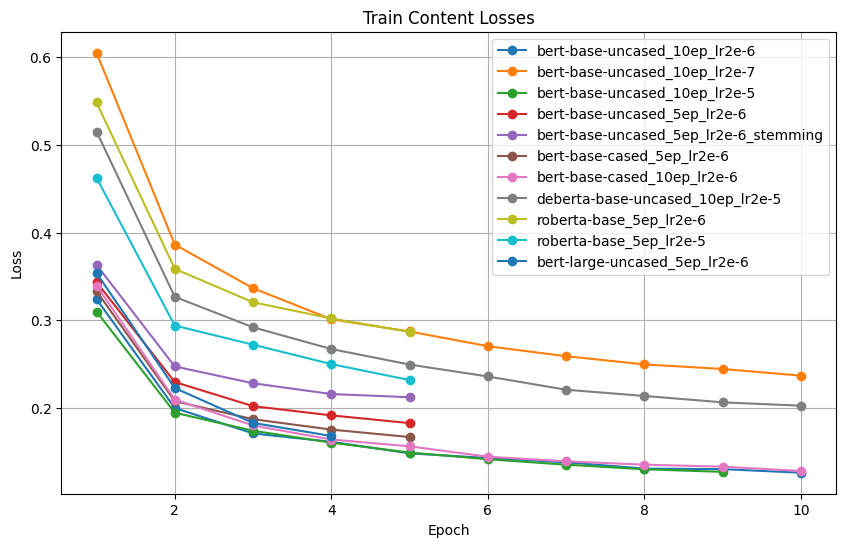

In [ ]:
plot_losses(train_content_losses, names, 'Train Content Losses')

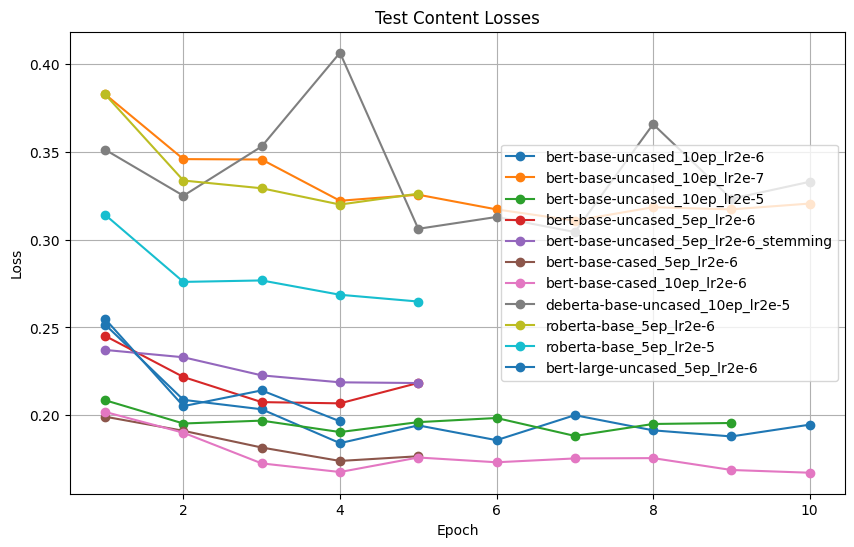

In [ ]:
plot_losses(test_content_losses, names, 'Test Content Losses')

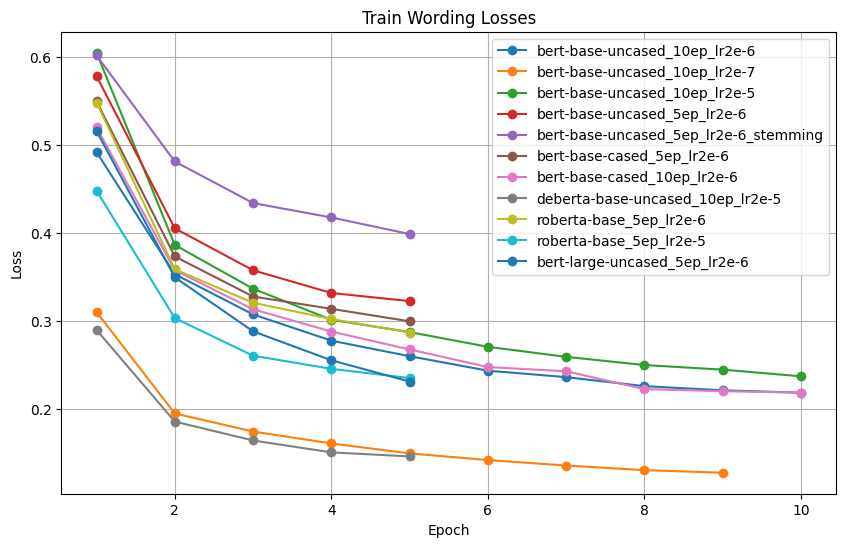

In [ ]:
plot_losses(train_wording_losses, names, 'Train Wording Losses')

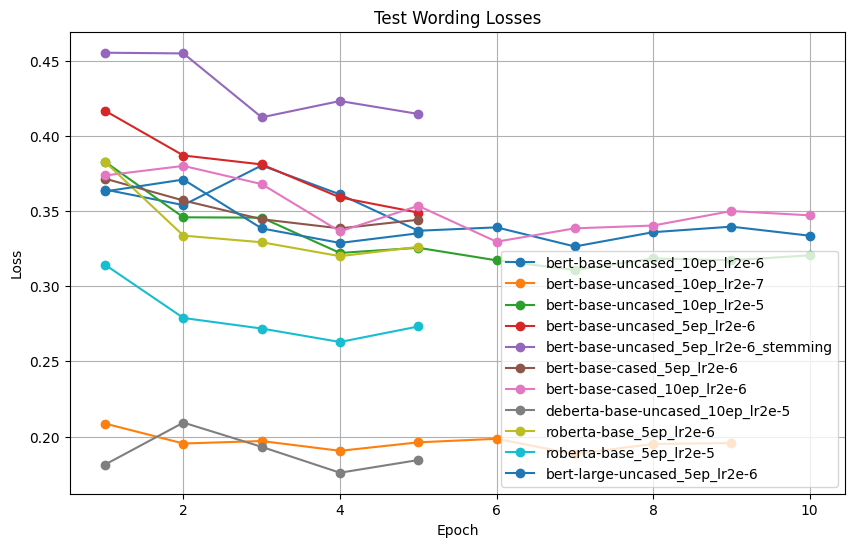

In [ ]:
plot_losses(test_wording_losses, names, 'Test Wording Losses')

**Та-дам!**
Вот они прекрасные графики. Думаю, понятно, что значения loss должны с каждой иттерацией уменьшать. Что и просиходит в рамках общей тенденции на всех графиках. Для train части явно наблюдается классическая логарифмическая структура графика. Так что тут все тоже глобально в норме. Расписывать еще что-то конкретное про графики не вижу смысла. Они вполне информативные. Обращу лишь внимание на пару фактов:



---


*   Хоть и в content части кажется, что cased (версия делающая различия в регистре) лучше, но на деле оказалось что это совершенно не так. В wording части она в целом хуже себя показывает, что невелирует ее преимущества. Более того, в закрытой валидации на kaggle мне ни разу не удалось превысить результат любой из uncased версий с схожими параметрами. Что казалось бы должно было быть не так, учитывая что у нас есть wording оценка. В ней это должно было играть роль. Но, увы, меньше токенов, лучше качество. Даже в казалось бы идеальной для иного расклада ситуации


---


*   На графики не попал вариант с нормализацией. Но, думаю, показатели обучения со стеммингом и так все показывают. С нормализацией результат был еще хуже. Что-то около 0.9. И в kaggle валидации они тоже показали себя на порядок хуже. И именно из-за этого я их и не применял.


---


*   Более тяжелые модели тут обучались на 5 иттерациях вместо 10. НУ ЭТО ЖЕ НЕ ПРАВИЛЬНОЕ СРАВНЕНИЕ - скажет кто-то. А я отвечу, что по времени они как раз и занимали в среднем на одну иттерацию в два раза больше времени. Тогда уже стоило и там увеличивать кол-во эпох. В любом случае, на скор это сильно не повлияло. Даже наоборот. О чем далее


---


*   На графиках уже видно, что к 10 иттерации скорость уменьшения заметно падает. Так как у меня не было много gpu ресурсов, я решил дальше особо не лезть. И как оказалось не зря. В закрытой kaggle валидации большинство моих моделей обученных на 5 эпохах показали скор заметно лучше чем на 10. В среднем на 20-25 процентов или 0.1 по mcrmse. Сложно сказать почему так. Первая моя мысль была - переобучение. Но нет, на графиках трейн снижение с 5 по 10 иттерации вполне заметно. Да, скор на тесте почти горизонтален. Что наверное и говорит что проблема в перобучении. Но все таки 5 эпох как-то уж слишком мало для этого. И подозреваю, стоит посмотреть результаты и на более длительном интервале, чтобы узнать истинный ответ.


---
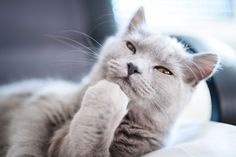



**Теперь давайте взгянем на сравнение по метрике MCRMSE**

In [ ]:
names = [res.name for res in res_list]
mcrmse_values = [res.mcrmse for res in res_list]

**Добавляем пару новых сокров**

*Для них сохранились лишь итоговые результаты тюкю я их писал на бумажке... Да я знаю, гениально. Но ведь сработало же, они сохранились*

In [ ]:
names.append("bert-base-uncased_5ep_lr2e-6_norm")
mcrmse_values.append(0.911638394)

names.append("Tf-IDF")
mcrmse_values.append(0.6493002834689034)

names.append("Bag of words")
mcrmse_values.append(0.8362184672841317)

names.append("Text Info features")
mcrmse_values.append(0.6713600479897124)

names.append("bert-large-cased_10ep_lr2e-4")
mcrmse_values.append(0.6751832581983588)

names.append("bert-large-uncased_5ep_unknown")
mcrmse_values.append(0.614)

names.append("albert_5ep_lr2e-6")
mcrmse_values.append(0.58654957518914122)

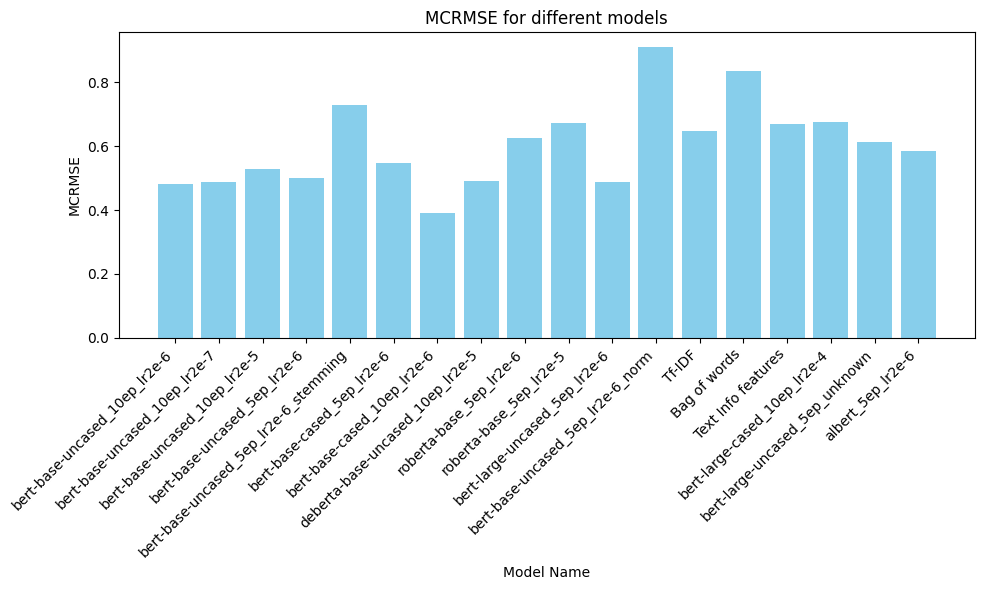

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10,6))
plt.bar(names, mcrmse_values, color='skyblue')
plt.title('MCRMSE for different models')
plt.xlabel('Model Name')
plt.ylabel('MCRMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Или же вот График с улучшением читаемости путем обратной пропорциональности и сортировкой. (Тут чем выше столбец, тем лучше скор модели)**

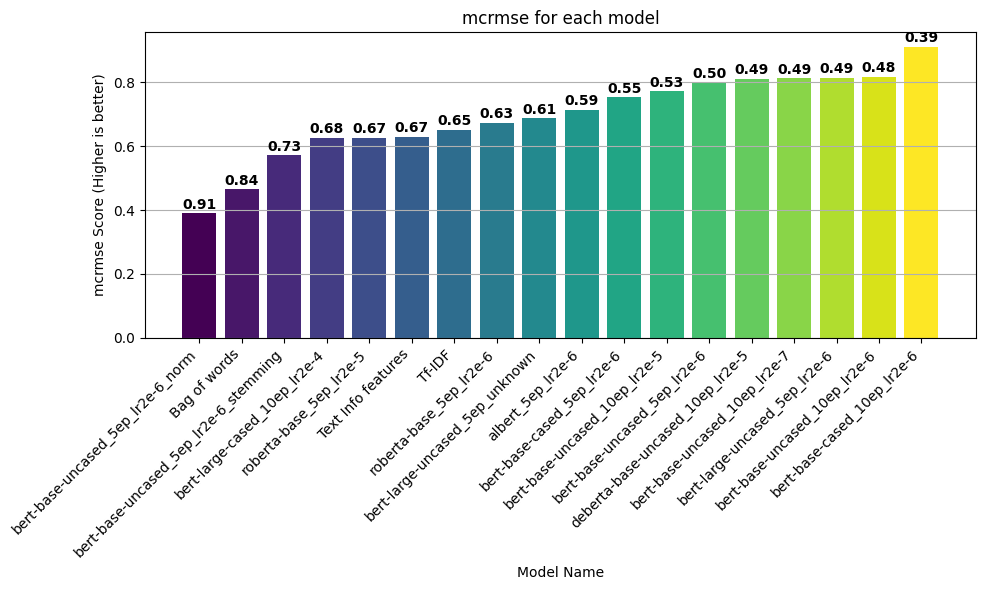

In [ ]:
def plot_mcrmse_bar_chart(names, mcrmse_values):
    sorted_indices = np.argsort(mcrmse_values)[::-1]
    sorted_names = [names[i] for i in sorted_indices]
    sorted_mcrmse = [mcrmse_values[i] for i in sorted_indices]

    plt.figure(figsize=(10,6))

    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_names)))

    plt.bar(sorted_names, [max(sorted_mcrmse) - m + min(sorted_mcrmse) for m in sorted_mcrmse], color=colors)

    for i, v in enumerate(sorted_mcrmse):
        plt.text(i, max(sorted_mcrmse) - v + min(sorted_mcrmse) + 0.005, "{:.2f}".format(v),
                 ha='center', va='bottom', fontweight='bold')

    plt.title('mcrmse for each model')
    plt.xlabel('Model Name')
    plt.ylabel('mcrmse Score (Higher is better)')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()


plot_mcrmse_bar_chart(names, mcrmse_values)


**Красиво, не правда ли?**

Но ближе к делу. Собственно, тут вообще про суть графика говорить не стоит. Простой результат по MCRMSE. Все видно, понятно. Из интересного:


*   На первом месте - cased модель. В kaggle валидации, как я и сказал, не одна cased не победила uncased. Да и чтобы такой разгромный счет был. Почти на 0.1. Думаю, тут как-то с весами очень модели повезло. Или в тестовую выборку попали слишком благоприятные для нее случаи. Вообщем, я бы назвал это скорее случайность. Но нужно в дальнейшем проверить его поподробнее.

*   Почти все первые позиции занимает bert-base-uncased. Это и не удивительно. В рамках этой задачи модель показала себя превосходно. В соотношени времени затрачиваемого на обучение и качества предсказаний она лучше любого варианта. Да даже мой лучший скор был получен на ней

*   Достаточно интересно, насколько ухудшает результаты работы нормализация и стемминг. Честно сказать, я даже подозреваю, что я мог где-то сделать их неправильно. Ну не может же он ухудшить работу почти в два раза (Речь про нормализацию. Сходный набор праметров без нее ближе к топу). Причем в рамках других моих nlp задач она вполне помогала. Впредь буду осторожнее к ней относиться и тщательнее тестировать. Попробую перепроверить в рамках этой задачи

*   В целом видно, что модели на 5 эпохах не сильно уступают по качеству моделям на 10. Как я уже выше писал, они были даже лучше в закрытом тесте. С другой стороны тут все же 10 эпох в среднем превосходят мои 5. Так что, подозреваю, что в kaggle они подключают свой даже свой закрытый train датасет, а не только test...



#Conclusion

## А что в итоге?

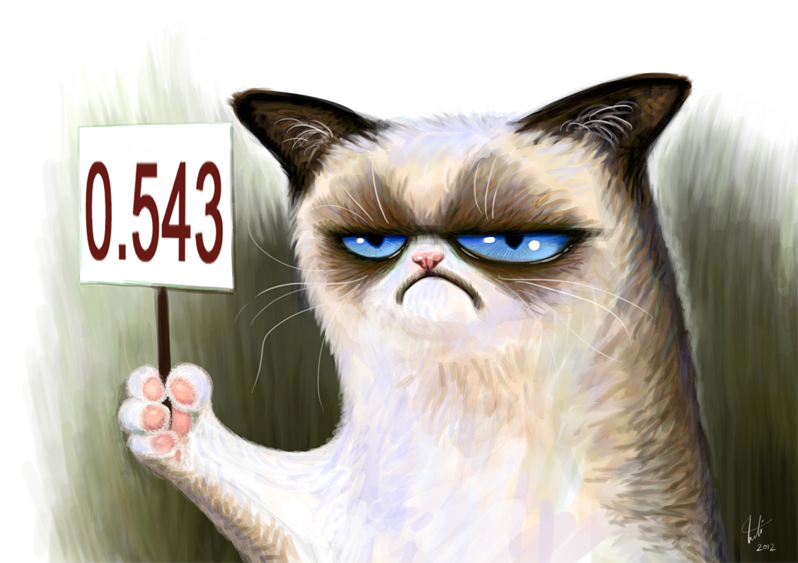

В итоге мы имеем лучшим вариантом bert-base-uncased на 5 эпохах. Он выдал скор в закрытом тесте **0.543**. Что поставило меня в **40%** лучших участников. Так как это был один из моих первых вариантов, а соревнование очень активное, то сейчас я конечно уже упал несколько ниже в лидерборде. Но все равно, в рамках текущей архитектуры я превосхожу почти все представленные решения. Я имею ввиду в рамках 2 моделей. Я вскоре осознал, что все же это не самое эффективное решения для этой задачи. Об этом распишу ниже. Думал, что  тестирование разных версий сможет улучшить результат. НО увы...


---



Вообще, стоит сказать, что как-то странно с этим соревнованием получилось. Почти все пошло ровно наоборот тому, что я ожидал. cased оказался хуже uncased. Лучший моделью оказалась самая легкая. Закрыли даже train. И т.д... В результате почти все мои попытки оказывались хуже самых начальных. Под конец, когда скор от стемминга упал в 2 раза, я вообще чуть не выпал. Но главной проблемой я бы назвал все таки отсутсвие стабильного источник gpu. В коллабе с этим все же помогает плюс. Но он не бесконечен и достаточно быстро сгорает. А на бесплатной версии нужен постоянный контроль, чтобы она просто не вылетела из-за Afk. Так что на ночь не оставишь... а, на компе есть видеокарта, но, как говориться, gtx не tesla. Так что такое себе... Был бы стабильный источник gpu, я бы мог постоянно тестировать модели и подходы. А так пришлось сконцентрироваться на одном. И, увы, не самом удачном.

## Что дальше?

Я вообще не планирую на этом заканчивать. Этот отчет я бы назвал скорее концом текущего подхода. (Как раз gpu в очередной раз закончились...) Далее хоть я и планирую проверить некторые гипотизы и аномалии описанные по ходу отчета, я хочу полностью поменять архитектуру модели.

Многие скоры выше моего используют единый кастомный трансформер с различными слоями и выводом всех результатов в рамках обучения одной модели. Именно это я и хочу написать. Также затрону и темы, которые я почти не трогал тут. То есть добавлю их как отдельные токены для улучшения модели. Некоторые люди туда еще умудряются вставить тектстовые фичи. И Так как подход показал себя в целом не так плохо, то тоже попытаюсь. Так что, ждем gpu, и поехали, так сказать...

## Бонусная секция: Тестирование на рандомных данных

Это я уже скорее ради развлечения решил попробовать. Как я уже где-то там писал, понять как и почему в оценках именно такие границы и по какой формуле эссе присуждалась конкретная оценка почти невозможно. Так что тестировать тут что-то нет особого смысла. НО, мы можем попросить ChatGPT написать 2 небольших абзаца текста, на выбранную тему. И попросить в одном высказаться более логично, а в другом нести чушь. И сравнить результаты их оценки.

Я выбрал тему Egyptian Social Structure

**1. A Brief Overview of Egyptian Social Structure**

The social structure of ancient Egypt was a reflection of its culture's belief in order, hierarchy, and the centrality of the state. At the apex of the social pyramid stood the pharaoh, believed to be a living god and the intermediary between the people and the deities. His role was pivotal, not only as a political leader but as the spiritual and religious figurehead, maintaining Ma'at, or cosmic order.

Directly beneath the pharaoh was the upper class, comprising of priests, nobles, and officials. The priests held significant sway, overseeing religious ceremonies, and managing vast temple estates. The nobles and officials were responsible for governance, administration, and ensuring that the pharaoh's decrees were implemented across the vast Egyptian territory.

Below the upper class, the middle class was emerging, consisting of merchants, artisans, scribes, and skilled workers. The scribes, in particular, held an essential role as they were responsible for recording and documenting the state's affairs, history, and religious texts. The advancements in art, architecture, and commerce can be credited to this burgeoning middle class.

The majority of the Egyptian population, however, belonged to the lower class, primarily made up of farmers and laborers. They worked the fertile lands along the Nile, provided the state with its primary economic resource, and were responsible for constructing monumental structures like the pyramids.

At the very bottom of the social structure were the slaves, who were often captives from wars or foreign lands. They were used for large-scale construction projects, mining, and domestic work.

In conclusion, ancient Egyptian society was a complex interplay of roles and responsibilities, bound together by the belief in the pharaoh's divinity and the need to maintain harmony and balance.


**2. The "True" Story of Egyptian Social Structure**

In ancient Egypt, there was a little-known but highly significant hierarchy based on the Egyptians' love for cats. At the top of the pyramid was the Great Sphinx Cat, a celestial feline who was said to control the Nile's ebb and flow with the flick of its tail. This mystical creature had a council of cat advisors who whispered secrets of the universe into its ears.

Beneath the Sphinx Cat was the elite class of "Purrists", priests and priestesses who danced and chanted to the tune of "meow" and ensured a steady supply of catnip to the sacred temples. They wore elaborate cat-ear headdresses and hosted grand balls where they'd mimic their feline overlords.

The middle class consisted of cat trainers, who choreographed impressive feline acrobatics and showcased them in the grand arenas. Cat jousting was a popular sport, with cats riding on beetles and competing for the golden fish prize.

Farmers, on the other hand, were revered for growing the finest cat grass and making toys filled with bells and feathers. The majority of the population, however, was occupied with the daily task of lint rolling – ensuring that every surface in Egypt remained fur-free.

The lowest class, surprisingly, were the dog enthusiasts, often relegated to the outskirts of society. They secretly gathered in underground kennels, dreaming of a day when barking would resonate through the land.

In short, ancient Egypt's social structure was a purrfectly intricate system revolving around their love and reverence for cats. So next time you see a cat, remember, it might just have a lineage of Egyptian royalty in its genes!

"*Первое эссе дает реальное представление о социальной структуре Древнего Египта, основанное на исторических данных. Второе эссе – это выдумка и абсолютная чушь, представляющая Египет как общество, ориентированное на котов.*" **- говорит нам ChatGpt**




Коты - это хорошо. Но давайте же посмотрим что нам скажут наши модели. Вдруг все же это ChatGpt ошибается и коты действительно были на вершине Египетской иерархии

In [ ]:
with open('bert.pkl', 'rb') as inp:
    tok = pickle.load(inp)
regressor_wording = BertRegressor(
        model_load_path ='bert_wording.pt',
        tokenizer = tok,
        save_path='B.pt')
regressor_content = BertRegressor(
        model_load_path ='bert_content.pt',
        tokenizer = tok,
        save_path='B.pt')

In [ ]:
text1 = '''The social structure of ancient Egypt was a reflection of its culture's belief in order, hierarchy, and the centrality of the state. At the apex of the social pyramid stood the pharaoh, believed to be a living god and the intermediary between the people and the deities. His role was pivotal, not only as a political leader but as the spiritual and religious figurehead, maintaining Ma'at, or cosmic order.

Directly beneath the pharaoh was the upper class, comprising of priests, nobles, and officials. The priests held significant sway, overseeing religious ceremonies, and managing vast temple estates. The nobles and officials were responsible for governance, administration, and ensuring that the pharaoh's decrees were implemented across the vast Egyptian territory.

Below the upper class, the middle class was emerging, consisting of merchants, artisans, scribes, and skilled workers. The scribes, in particular, held an essential role as they were responsible for recording and documenting the state's affairs, history, and religious texts. The advancements in art, architecture, and commerce can be credited to this burgeoning middle class.

The majority of the Egyptian population, however, belonged to the lower class, primarily made up of farmers and laborers. They worked the fertile lands along the Nile, provided the state with its primary economic resource, and were responsible for constructing monumental structures like the pyramids.

At the very bottom of the social structure were the slaves, who were often captives from wars or foreign lands. They were used for large-scale construction projects, mining, and domestic work.

In conclusion, ancient Egyptian society was a complex interplay of roles and responsibilities, bound together by the belief in the pharaoh's divinity and the need to maintain harmony and balance.'''
text2 = '''In ancient Egypt, there was a little-known but highly significant hierarchy based on the Egyptians' love for cats. At the top of the pyramid was the Great Sphinx Cat, a celestial feline who was said to control the Nile's ebb and flow with the flick of its tail. This mystical creature had a council of cat advisors who whispered secrets of the universe into its ears.

Beneath the Sphinx Cat was the elite class of "Purrists", priests and priestesses who danced and chanted to the tune of "meow" and ensured a steady supply of catnip to the sacred temples. They wore elaborate cat-ear headdresses and hosted grand balls where they'd mimic their feline overlords.

The middle class consisted of cat trainers, who choreographed impressive feline acrobatics and showcased them in the grand arenas. Cat jousting was a popular sport, with cats riding on beetles and competing for the golden fish prize.

Farmers, on the other hand, were revered for growing the finest cat grass and making toys filled with bells and feathers. The majority of the population, however, was occupied with the daily task of lint rolling – ensuring that every surface in Egypt remained fur-free.

The lowest class, surprisingly, were the dog enthusiasts, often relegated to the outskirts of society. They secretly gathered in underground kennels, dreaming of a day when barking would resonate through the land.

In short, ancient Egypt's social structure was a purrfectly intricate system revolving around their love and reverence for cats. So next time you see a cat, remember, it might just have a lineage of Egyptian royalty in its genes!'''

In [ ]:
print(f"Wording score for text1: {regressor_wording.predict(text1)}\nContent score for text1: {regressor_content.predict(text1)}")

Wording score for text1: 2.6586625576019287
Content score for text1: 2.8261382579803467


In [ ]:
print(f"Wording score for text2: {regressor_wording.predict(text2)}\nContent score for text1: {regressor_content.predict(text2)}")

Wording score for text2: 2.547687530517578
Content score for text1: 2.4310739040374756


Эххх, все таки не так важны были коты в Египте... А жаль. Хотя, конечно, я ожидал скор гораздо меньше. И ведь главное, не поймешь какой скор поставили бы они...

Мяу

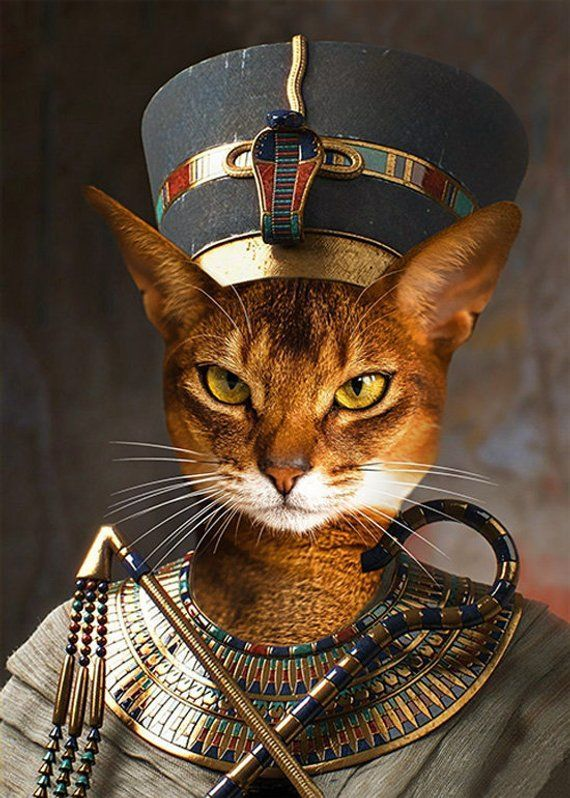